In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 312

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,747499,2013-01-02,312,60660000000.000,60632000000.000,933.333,5.160,-11.487
1,747500,2013-01-03,312,60161700000.000,60133700000.000,925.667,5.118,-11.393
2,747501,2013-01-04,312,62306400000.000,62278500000.000,958.667,5.300,-11.799
3,747502,2013-01-07,312,63739100000.000,63711100000.000,980.710,5.422,-12.070
4,747503,2013-01-08,312,62957900000.000,62929900000.000,968.690,5.356,-11.922


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio
2267,856213,312,2022-01-03,2022,1,NaN
2268,856214,312,2022-01-04,2022,1,NaN
2269,856215,312,2022-01-05,2022,1,NaN
2270,856216,312,2022-01-06,2022,1,NaN
2271,856217,312,2022-01-07,2022,1,NaN
...,...,...,...,...,...,...
2490,856436,312,2022-11-21,2022,4,NaN
2491,856437,312,2022-11-22,2022,4,NaN
2492,856438,312,2022-11-23,2022,4,NaN
2493,856439,312,2022-11-25,2022,4,NaN


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value
0,12842,312,2022,1,NaN
1,12843,312,2022,2,NaN
2,12844,312,2022,3,NaN


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
4,312,2021,0,NaN
9,312,2020,0,NaN
14,312,2019,0,NaN
19,312,2018,0,NaN
24,312,2017,0,NaN
29,312,2016,0,NaN
34,312,2015,0,NaN
39,312,2014,0,NaN
44,312,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio
2267,2267,312,2022-01-03,338.540,941737000000.000,939009000000.000,24.181,7.541,-4.525,2022-03-30,620194000000.000,2022,1,NaN
2268,2268,312,2022-01-04,336.530,936146000000.000,933418000000.000,24.038,7.496,-4.499,2022-03-31,605251000000.000,2022,1,NaN
2269,2269,312,2022-01-05,324.170,901763000000.000,899035000000.000,23.155,7.221,-4.333,2022-04-01,612029000000.000,2022,1,NaN
2270,2270,312,2022-01-06,332.460,924824000000.000,922096000000.000,23.747,7.406,-4.444,2022-04-04,636635000000.000,2022,1,NaN
2271,2271,312,2022-01-07,331.790,922960000000.000,920232000000.000,23.699,7.391,-4.435,2022-04-05,631055000000.000,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,312,2022-08-26,161.780,434792000000.000,438178000000.000,13.261,3.481,-0.406,2022-11-21,291299000000.000,2022,3,NaN
2431,2431,312,2022-08-29,159.170,427777000000.000,431163000000.000,13.047,3.425,-0.399,2022-11-22,295489000000.000,2022,3,NaN
2432,2432,312,2022-08-30,157.160,422375000000.000,425761000000.000,12.882,3.382,-0.394,2022-11-23,297610000000.000,2022,3,NaN
2433,2433,312,2022-08-31,162.930,437882000000.000,441268000000.000,13.355,3.506,-0.408,2022-11-25,295409000000.000,2022,3,NaN


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value
2267,2267,312,2022-01-03,338.540,941737000000.000,939009000000.000,24.181,7.541,-4.525,2022-03-30,620194000000.000,2022,1,NaN,NaN
2268,2268,312,2022-01-04,336.530,936146000000.000,933418000000.000,24.038,7.496,-4.499,2022-03-31,605251000000.000,2022,1,NaN,NaN
2269,2269,312,2022-01-05,324.170,901763000000.000,899035000000.000,23.155,7.221,-4.333,2022-04-01,612029000000.000,2022,1,NaN,NaN
2270,2270,312,2022-01-06,332.460,924824000000.000,922096000000.000,23.747,7.406,-4.444,2022-04-04,636635000000.000,2022,1,NaN,NaN
2271,2271,312,2022-01-07,331.790,922960000000.000,920232000000.000,23.699,7.391,-4.435,2022-04-05,631055000000.000,2022,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,312,2022-08-26,161.780,434792000000.000,438178000000.000,13.261,3.481,-0.406,2022-11-21,291299000000.000,2022,3,NaN,NaN
2431,2431,312,2022-08-29,159.170,427777000000.000,431163000000.000,13.047,3.425,-0.399,2022-11-22,295489000000.000,2022,3,NaN,NaN
2432,2432,312,2022-08-30,157.160,422375000000.000,425761000000.000,12.882,3.382,-0.394,2022-11-23,297610000000.000,2022,3,NaN,NaN
2433,2433,312,2022-08-31,162.930,437882000000.000,441268000000.000,13.355,3.506,-0.408,2022-11-25,295409000000.000,2022,3,NaN,NaN


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio
2267,2267,312,2022-01-03,338.540,941737000000.000,939009000000.000,24.181,7.541,-4.525,2022-03-30,620194000000.000,2022,1,NaN,NaN,2.811
2268,2268,312,2022-01-04,336.530,936146000000.000,933418000000.000,24.038,7.496,-4.499,2022-03-31,605251000000.000,2022,1,NaN,NaN,2.811
2269,2269,312,2022-01-05,324.170,901763000000.000,899035000000.000,23.155,7.221,-4.333,2022-04-01,612029000000.000,2022,1,NaN,NaN,2.811
2270,2270,312,2022-01-06,332.460,924824000000.000,922096000000.000,23.747,7.406,-4.444,2022-04-04,636635000000.000,2022,1,NaN,NaN,2.811
2271,2271,312,2022-01-07,331.790,922960000000.000,920232000000.000,23.699,7.391,-4.435,2022-04-05,631055000000.000,2022,1,NaN,NaN,2.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,312,2022-08-26,161.780,434792000000.000,438178000000.000,13.261,3.481,-0.406,2022-11-21,291299000000.000,2022,3,NaN,NaN,2.570
2431,2431,312,2022-08-29,159.170,427777000000.000,431163000000.000,13.047,3.425,-0.399,2022-11-22,295489000000.000,2022,3,NaN,NaN,2.570
2432,2432,312,2022-08-30,157.160,422375000000.000,425761000000.000,12.882,3.382,-0.394,2022-11-23,297610000000.000,2022,3,NaN,NaN,2.570
2433,2433,312,2022-08-31,162.930,437882000000.000,441268000000.000,13.355,3.506,-0.408,2022-11-25,295409000000.000,2022,3,NaN,NaN,2.570


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,312,2013-01-02,28.000,60660000000.000,60632000000.000,933.333,5.160,-11.487,2013-04-01,60815900000.000,2013,1,23.322,8.186,10.388,155900000.000,0.257
1,1,312,2013-01-03,27.770,60161700000.000,60133700000.000,925.667,5.118,-11.393,2013-04-02,60553800000.000,2013,1,23.130,8.186,10.388,392100000.000,0.652
2,2,312,2013-01-04,28.760,62306400000.000,62278500000.000,958.667,5.300,-11.799,2013-04-03,62531000000.000,2013,1,23.955,8.186,10.388,224600000.000,0.360
3,3,312,2013-01-07,29.421,63739100000.000,63711100000.000,980.710,5.422,-12.070,2013-04-04,64490300000.000,2013,1,24.505,8.186,10.388,751200000.000,1.179
4,4,312,2013-01-08,29.061,62957900000.000,62929900000.000,968.690,5.356,-11.922,2013-04-05,65246700000.000,2013,1,24.205,8.186,10.388,2288800000.000,3.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,312,2013-10-10,49.050,119452000000.000,116927000000.000,114.070,9.155,-0.120,2014-01-07,142184000000.000,2013,4,42.101,9.224,11.882,22732000000.000,19.030
196,196,312,2013-10-11,49.110,119599000000.000,117074000000.000,114.209,9.166,-0.120,2014-01-08,142945000000.000,2013,4,42.153,9.224,11.882,23346000000.000,19.520
197,197,312,2013-10-14,49.510,120573000000.000,118048000000.000,115.140,9.241,-0.121,2014-01-09,140465000000.000,2013,4,42.496,9.224,11.882,19892000000.000,16.498
198,198,312,2013-10-15,49.500,120548000000.000,118023000000.000,115.116,9.239,-0.121,2014-01-10,142233000000.000,2013,4,42.487,9.224,11.882,21685000000.000,17.989


# 1. Optimizing the random forest model

In [27]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [28]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [29]:
train.shape

(1069, 18)

In [30]:
validation.shape

(357, 18)

In [31]:
test.shape

(357, 18)

In [32]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.97it/s]

profit_perc_sum 1558.76 profit_perc_mean 6.468 denominator 241




model params:   2%|▏         | 2/96 [00:00<00:15,  5.94it/s]

profit_perc_sum 1628.349 profit_perc_mean 7.943 denominator 205




model params:   3%|▎         | 3/96 [00:00<00:23,  3.92it/s]

model params:   4%|▍         | 4/96 [00:00<00:20,  4.53it/s]

profit_perc_sum 1670.602 profit_perc_mean 8.071 denominator 207
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   5%|▌         | 5/96 [00:01<00:23,  3.79it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:30,  3.00it/s]



profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357


model params:   7%|▋         | 7/96 [00:01<00:25,  3.46it/s]

model params:   8%|▊         | 8/96 [00:02<00:28,  3.11it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   9%|▉         | 9/96 [00:02<00:34,  2.53it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  10%|█         | 10/96 [00:03<00:29,  2.94it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  11%|█▏        | 11/96 [00:03<00:31,  2.72it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:36,  2.32it/s]

model params:  14%|█▎        | 13/96 [00:04<00:28,  2.87it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1456.552 profit_perc_mean 5.202 denominator 280




model params:  15%|█▍        | 14/96 [00:04<00:27,  3.03it/s]

profit_perc_sum 1511.406 profit_perc_mean 5.904 denominator 256




model params:  16%|█▌        | 15/96 [00:04<00:28,  2.82it/s]



profit_perc_sum 1467.629 profit_perc_mean 5.337 denominator 275
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357


model params:  17%|█▋        | 16/96 [00:05<00:24,  3.31it/s]

model params:  18%|█▊        | 17/96 [00:05<00:24,  3.18it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  19%|█▉        | 18/96 [00:05<00:29,  2.65it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  20%|█▉        | 19/96 [00:06<00:25,  3.01it/s]

profit_perc_sum 523.238 profit_perc_mean 1.482 denominator 353




model params:  21%|██        | 20/96 [00:06<00:26,  2.82it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  22%|██▏       | 21/96 [00:07<00:32,  2.32it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  23%|██▎       | 22/96 [00:07<00:27,  2.70it/s]

profit_perc_sum 523.238 profit_perc_mean 1.482 denominator 353




model params:  24%|██▍       | 23/96 [00:07<00:28,  2.60it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  25%|██▌       | 24/96 [00:08<00:34,  2.10it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  26%|██▌       | 25/96 [00:08<00:27,  2.54it/s]

profit_perc_sum 1342.34 profit_perc_mean 5.285 denominator 254




model params:  27%|██▋       | 26/96 [00:09<00:26,  2.67it/s]

profit_perc_sum 1485.72 profit_perc_mean 5.628 denominator 264




model params:  28%|██▊       | 27/96 [00:09<00:26,  2.60it/s]



profit_perc_sum 1470.418 profit_perc_mean 5.446 denominator 270
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357


model params:  29%|██▉       | 28/96 [00:09<00:21,  3.10it/s]

model params:  30%|███       | 29/96 [00:09<00:22,  3.00it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  31%|███▏      | 30/96 [00:10<00:26,  2.51it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  32%|███▏      | 31/96 [00:10<00:23,  2.76it/s]

profit_perc_sum 507.724 profit_perc_mean 1.459 denominator 348




model params:  33%|███▎      | 32/96 [00:11<00:24,  2.57it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  34%|███▍      | 33/96 [00:11<00:30,  2.06it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  35%|███▌      | 34/96 [00:12<00:25,  2.39it/s]

profit_perc_sum 507.724 profit_perc_mean 1.459 denominator 348




model params:  36%|███▋      | 35/96 [00:12<00:26,  2.34it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  38%|███▊      | 36/96 [00:13<00:29,  2.00it/s]

model params:  39%|███▊      | 37/96 [00:13<00:23,  2.56it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1488.822 profit_perc_mean 5.576 denominator 267




model params:  40%|███▉      | 38/96 [00:13<00:20,  2.84it/s]

profit_perc_sum 1491.026 profit_perc_mean 5.713 denominator 261




model params:  41%|████      | 39/96 [00:14<00:20,  2.79it/s]

model params:  42%|████▏     | 40/96 [00:14<00:17,  3.29it/s]

profit_perc_sum 1467.629 profit_perc_mean 5.337 denominator 275
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  43%|████▎     | 41/96 [00:14<00:17,  3.13it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  44%|████▍     | 42/96 [00:15<00:19,  2.70it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  45%|████▍     | 43/96 [00:15<00:17,  3.08it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  46%|████▌     | 44/96 [00:15<00:18,  2.82it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  47%|████▋     | 45/96 [00:16<00:22,  2.31it/s]



profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335


model params:  48%|████▊     | 46/96 [00:16<00:18,  2.74it/s]

model params:  49%|████▉     | 47/96 [00:17<00:18,  2.61it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  50%|█████     | 48/96 [00:17<00:21,  2.21it/s]

model params:  51%|█████     | 49/96 [00:17<00:16,  2.85it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1667.373 profit_perc_mean 7.187 denominator 232




model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.18it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  53%|█████▎    | 51/96 [00:18<00:14,  3.10it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:12,  3.62it/s]

profit_perc_sum 1696.394 profit_perc_mean 8.156 denominator 208
profit_perc_sum 1883.635 profit_perc_mean 8.641 denominator 218




model params:  55%|█████▌    | 53/96 [00:18<00:12,  3.41it/s]

profit_perc_sum 1401.462 profit_perc_mean 5.432 denominator 258




model params:  56%|█████▋    | 54/96 [00:19<00:14,  2.95it/s]

profit_perc_sum 1091.774 profit_perc_mean 3.714 denominator 294
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  57%|█████▋    | 55/96 [00:19<00:12,  3.35it/s]

model params:  58%|█████▊    | 56/96 [00:19<00:12,  3.11it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  59%|█████▉    | 57/96 [00:20<00:15,  2.58it/s]



profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357


model params:  60%|██████    | 58/96 [00:20<00:12,  3.03it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.86it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  62%|██████▎   | 60/96 [00:21<00:15,  2.38it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:11,  3.02it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1493.987 profit_perc_mean 5.976 denominator 250




model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.26it/s]

profit_perc_sum 1316.843 profit_perc_mean 5.556 denominator 237




model params:  66%|██████▌   | 63/96 [00:22<00:10,  3.03it/s]



profit_perc_sum 1472.731 profit_perc_mean 5.867 denominator 251
profit_perc_sum 902.264 profit_perc_mean 2.646 denominator 341


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.48it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.28it/s]

profit_perc_sum 1346.044 profit_perc_mean 4.532 denominator 297




model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.69it/s]

profit_perc_sum 1196.117 profit_perc_mean 3.883 denominator 308




model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.04it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  71%|███████   | 68/96 [00:24<00:10,  2.76it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.22it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  73%|███████▎  | 70/96 [00:24<00:09,  2.63it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  74%|███████▍  | 71/96 [00:25<00:10,  2.45it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.98it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.55it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.83it/s]

profit_perc_sum 1607.032 profit_perc_mean 7.878 denominator 204




model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.76it/s]



profit_perc_sum 1780.694 profit_perc_mean 8.094 denominator 220
profit_perc_sum 936.573 profit_perc_mean 2.763 denominator 339


model params:  79%|███████▉  | 76/96 [00:27<00:06,  3.22it/s]

model params:  80%|████████  | 77/96 [00:27<00:06,  3.09it/s]

profit_perc_sum 1022.763 profit_perc_mean 3.081 denominator 332




model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.57it/s]

profit_perc_sum 829.918 profit_perc_mean 2.406 denominator 345




model params:  82%|████████▏ | 79/96 [00:28<00:05,  2.90it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.60it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  84%|████████▍ | 81/96 [00:29<00:07,  2.06it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.44it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  86%|████████▋ | 83/96 [00:30<00:05,  2.35it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.97it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.52it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1491.026 profit_perc_mean 5.713 denominator 261




model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.79it/s]

profit_perc_sum 1486.523 profit_perc_mean 5.899 denominator 252




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.73it/s]

profit_perc_sum 1494.341 profit_perc_mean 5.837 denominator 256




model params:  92%|█████████▏| 88/96 [00:31<00:02,  3.13it/s]

profit_perc_sum 1103.054 profit_perc_mean 3.535 denominator 312




model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.93it/s]

profit_perc_sum 1348.674 profit_perc_mean 4.526 denominator 298




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.38it/s]

profit_perc_sum 621.084 profit_perc_mean 1.759 denominator 353




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.73it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.52it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  97%|█████████▋| 93/96 [00:34<00:01,  2.03it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.41it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.29it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params: 100%|██████████| 96/96 [00:35<00:00,  2.69it/s]

model threshold:  17%|█▋        | 1/6 [00:35<02:58, 35.68s/it]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.63it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:   2%|▏         | 2/96 [00:00<00:15,  6.10it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:   3%|▎         | 3/96 [00:00<00:21,  4.42it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.35it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203
profit_perc_sum 1454.695 profit_perc_mean 6.164 denominator 236




model params:   5%|▌         | 5/96 [00:00<00:19,  4.77it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:23,  3.78it/s]

model params:   7%|▋         | 7/96 [00:01<00:20,  4.36it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   8%|▊         | 8/96 [00:01<00:22,  3.96it/s]

profit_perc_sum 485.491 profit_perc_mean 1.411 denominator 344




model params:   9%|▉         | 9/96 [00:02<00:27,  3.19it/s]

model params:  10%|█         | 10/96 [00:02<00:22,  3.82it/s]

profit_perc_sum 485.491 profit_perc_mean 1.411 denominator 344
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  11%|█▏        | 11/96 [00:02<00:24,  3.54it/s]

profit_perc_sum 485.491 profit_perc_mean 1.411 denominator 344




model params:  12%|█▎        | 12/96 [00:03<00:28,  2.92it/s]

model params:  14%|█▎        | 13/96 [00:03<00:22,  3.66it/s]

profit_perc_sum 485.491 profit_perc_mean 1.411 denominator 344
profit_perc_sum 1242.817 profit_perc_mean 5.222 denominator 238




model params:  15%|█▍        | 14/96 [00:03<00:21,  3.86it/s]

profit_perc_sum 1603.854 profit_perc_mean 7.862 denominator 204




model params:  16%|█▌        | 15/96 [00:03<00:23,  3.52it/s]

model params:  17%|█▋        | 16/96 [00:04<00:19,  4.11it/s]

profit_perc_sum 1240.127 profit_perc_mean 5.277 denominator 235
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  18%|█▊        | 17/96 [00:04<00:20,  3.83it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  19%|█▉        | 18/96 [00:04<00:24,  3.19it/s]



profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335


model params:  20%|█▉        | 19/96 [00:04<00:21,  3.62it/s]

model params:  21%|██        | 20/96 [00:05<00:22,  3.31it/s]

profit_perc_sum 523.238 profit_perc_mean 1.482 denominator 353




model params:  22%|██▏       | 21/96 [00:05<00:28,  2.68it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  23%|██▎       | 22/96 [00:06<00:23,  3.09it/s]

model params:  24%|██▍       | 23/96 [00:06<00:24,  2.95it/s]

profit_perc_sum 523.238 profit_perc_mean 1.482 denominator 353




model params:  25%|██▌       | 24/96 [00:07<00:28,  2.50it/s]

model params:  26%|██▌       | 25/96 [00:07<00:22,  3.15it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1301.325 profit_perc_mean 5.538 denominator 235




model params:  27%|██▋       | 26/96 [00:07<00:20,  3.41it/s]

profit_perc_sum 1454.081 profit_perc_mean 5.935 denominator 245




model params:  28%|██▊       | 27/96 [00:07<00:21,  3.24it/s]

model params:  29%|██▉       | 28/96 [00:07<00:18,  3.75it/s]

profit_perc_sum 1493.987 profit_perc_mean 5.976 denominator 250
profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  30%|███       | 29/96 [00:08<00:18,  3.54it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  31%|███▏      | 30/96 [00:08<00:22,  2.90it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  32%|███▏      | 31/96 [00:08<00:20,  3.24it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  33%|███▎      | 32/96 [00:09<00:22,  2.85it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  34%|███▍      | 33/96 [00:10<00:27,  2.28it/s]

profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  35%|███▌      | 34/96 [00:10<00:23,  2.67it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  36%|███▋      | 35/96 [00:10<00:23,  2.56it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  38%|███▊      | 36/96 [00:11<00:27,  2.20it/s]

model params:  39%|███▊      | 37/96 [00:11<00:20,  2.84it/s]

profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342
profit_perc_sum 1183.785 profit_perc_mean 5.261 denominator 225




model params:  40%|███▉      | 38/96 [00:11<00:18,  3.09it/s]

profit_perc_sum 1432.276 profit_perc_mean 5.799 denominator 247




model params:  41%|████      | 39/96 [00:12<00:19,  2.97it/s]

model params:  42%|████▏     | 40/96 [00:12<00:16,  3.46it/s]

profit_perc_sum 1472.731 profit_perc_mean 5.867 denominator 251
profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  43%|████▎     | 41/96 [00:12<00:16,  3.31it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  44%|████▍     | 42/96 [00:12<00:19,  2.80it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  45%|████▍     | 43/96 [00:13<00:16,  3.20it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  46%|████▌     | 44/96 [00:13<00:18,  2.86it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  47%|████▋     | 45/96 [00:14<00:22,  2.32it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  48%|████▊     | 46/96 [00:14<00:18,  2.72it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  49%|████▉     | 47/96 [00:14<00:18,  2.60it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  50%|█████     | 48/96 [00:15<00:22,  2.16it/s]

model params:  51%|█████     | 49/96 [00:15<00:16,  2.80it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 1499.875 profit_perc_mean 8.522 denominator 176




model params:  52%|█████▏    | 50/96 [00:15<00:14,  3.17it/s]

profit_perc_sum 1496.632 profit_perc_mean 8.456 denominator 177




model params:  53%|█████▎    | 51/96 [00:16<00:14,  3.04it/s]



profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203
profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203


model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.51it/s]

model params:  55%|█████▌    | 53/96 [00:16<00:12,  3.34it/s]

profit_perc_sum 1549.942 profit_perc_mean 6.54 denominator 237




model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.82it/s]



profit_perc_sum 1462.902 profit_perc_mean 5.923 denominator 247
profit_perc_sum 827.718 profit_perc_mean 2.463 denominator 336


model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.25it/s]

model params:  58%|█████▊    | 56/96 [00:17<00:13,  2.99it/s]

profit_perc_sum 680.631 profit_perc_mean 1.973 denominator 345




model params:  59%|█████▉    | 57/96 [00:18<00:15,  2.46it/s]



profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 827.718 profit_perc_mean 2.463 denominator 336


model params:  60%|██████    | 58/96 [00:18<00:13,  2.91it/s]

model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.76it/s]

profit_perc_sum 680.631 profit_perc_mean 1.973 denominator 345




model params:  62%|██████▎   | 60/96 [00:19<00:15,  2.38it/s]

model params:  64%|██████▎   | 61/96 [00:19<00:11,  2.98it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1512.84 profit_perc_mean 8.222 denominator 184




model params:  65%|██████▍   | 62/96 [00:19<00:10,  3.17it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  66%|██████▌   | 63/96 [00:20<00:10,  3.00it/s]

model params:  67%|██████▋   | 64/96 [00:20<00:09,  3.46it/s]

profit_perc_sum 1336.774 profit_perc_mean 5.863 denominator 228
profit_perc_sum 1402.871 profit_perc_mean 4.788 denominator 293




model params:  68%|██████▊   | 65/96 [00:20<00:09,  3.25it/s]

profit_perc_sum 1494.706 profit_perc_mean 5.908 denominator 253




model params:  69%|██████▉   | 66/96 [00:21<00:10,  2.74it/s]

profit_perc_sum 1481.709 profit_perc_mean 5.765 denominator 257




model params:  70%|██████▉   | 67/96 [00:21<00:09,  3.08it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  71%|███████   | 68/96 [00:22<00:10,  2.77it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  72%|███████▏  | 69/96 [00:22<00:12,  2.21it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  73%|███████▎  | 70/96 [00:22<00:09,  2.60it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  74%|███████▍  | 71/96 [00:23<00:10,  2.46it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  75%|███████▌  | 72/96 [00:24<00:11,  2.07it/s]

model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.64it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1377.344 profit_perc_mean 7.695 denominator 179




model params:  77%|███████▋  | 74/96 [00:24<00:07,  2.91it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  78%|███████▊  | 75/96 [00:24<00:07,  2.81it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203
profit_perc_sum 1459.71 profit_perc_mean 5.195 denominator 281




model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.25it/s]

model params:  80%|████████  | 77/96 [00:25<00:06,  3.08it/s]

profit_perc_sum 1479.221 profit_perc_mean 5.399 denominator 274




model params:  81%|████████▏ | 78/96 [00:25<00:06,  2.57it/s]

profit_perc_sum 1465.331 profit_perc_mean 5.196 denominator 282




model params:  82%|████████▏ | 79/96 [00:26<00:05,  2.93it/s]

profit_perc_sum 965.52 profit_perc_mean 2.962 denominator 326




model params:  83%|████████▎ | 80/96 [00:26<00:06,  2.59it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  84%|████████▍ | 81/96 [00:27<00:07,  2.07it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  85%|████████▌ | 82/96 [00:27<00:05,  2.42it/s]

profit_perc_sum 965.52 profit_perc_mean 2.962 denominator 326




model params:  86%|████████▋ | 83/96 [00:28<00:05,  2.28it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  88%|████████▊ | 84/96 [00:28<00:06,  1.90it/s]

model params:  89%|████████▊ | 85/96 [00:29<00:04,  2.45it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1511.406 profit_perc_mean 5.904 denominator 256




model params:  90%|████████▉ | 86/96 [00:29<00:03,  2.68it/s]

profit_perc_sum 1559.594 profit_perc_mean 6.608 denominator 236




model params:  91%|█████████ | 87/96 [00:29<00:03,  2.56it/s]



profit_perc_sum 1564.088 profit_perc_mean 6.49 denominator 241
profit_perc_sum 1460.128 profit_perc_mean 5.252 denominator 278


model params:  92%|█████████▏| 88/96 [00:29<00:02,  2.98it/s]

model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.85it/s]

profit_perc_sum 1477.477 profit_perc_mean 5.472 denominator 270




model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.38it/s]

profit_perc_sum 1460.128 profit_perc_mean 5.252 denominator 278




model params:  95%|█████████▍| 91/96 [00:31<00:01,  2.69it/s]

profit_perc_sum 964.713 profit_perc_mean 2.854 denominator 338




model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.41it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  97%|█████████▋| 93/96 [00:32<00:01,  1.93it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.28it/s]

profit_perc_sum 964.713 profit_perc_mean 2.854 denominator 338




model params:  99%|█████████▉| 95/96 [00:33<00:00,  2.18it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params: 100%|██████████| 96/96 [00:33<00:00,  2.83it/s]

model threshold:  33%|███▎      | 2/6 [01:09<02:18, 34.67s/it]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:   0%|          | 0/96 [00:00<?, ?it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:   2%|▏         | 2/96 [00:00<00:14,  6.61it/s]

profit_perc_sum 1578.719 profit_perc_mean 7.933 denominator 199




model params:   3%|▎         | 3/96 [00:00<00:19,  4.68it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.32it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203
profit_perc_sum 1320.528 profit_perc_mean 6.537 denominator 202




model params:   5%|▌         | 5/96 [00:01<00:19,  4.63it/s]

profit_perc_sum 1512.421 profit_perc_mean 6.074 denominator 249




model params:   6%|▋         | 6/96 [00:01<00:25,  3.50it/s]



profit_perc_sum 1515.962 profit_perc_mean 6.016 denominator 252
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335


model params:   7%|▋         | 7/96 [00:01<00:22,  3.94it/s]

model params:   8%|▊         | 8/96 [00:01<00:24,  3.56it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:   9%|▉         | 9/96 [00:02<00:29,  2.90it/s]



profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335


model params:  10%|█         | 10/96 [00:02<00:25,  3.35it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.14it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.67it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.38it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.58it/s]

profit_perc_sum 1499.875 profit_perc_mean 8.522 denominator 176




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.34it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.89it/s]

profit_perc_sum 1525.965 profit_perc_mean 8.16 denominator 187
profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.61it/s]

profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  19%|█▉        | 18/96 [00:05<00:26,  2.97it/s]



profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342
profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.39it/s]

model params:  21%|██        | 20/96 [00:05<00:24,  3.08it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.47it/s]



profit_perc_sum 470.488 profit_perc_mean 1.38 denominator 341
profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.91it/s]

model params:  24%|██▍       | 23/96 [00:06<00:25,  2.83it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.39it/s]

model params:  26%|██▌       | 25/96 [00:07<00:23,  3.03it/s]

profit_perc_sum 470.488 profit_perc_mean 1.38 denominator 341
profit_perc_sum 1546.262 profit_perc_mean 8.45 denominator 183




model params:  27%|██▋       | 26/96 [00:07<00:21,  3.30it/s]

profit_perc_sum 1546.262 profit_perc_mean 8.45 denominator 183




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.11it/s]

model params:  29%|██▉       | 28/96 [00:08<00:18,  3.60it/s]

profit_perc_sum 1537.333 profit_perc_mean 8.007 denominator 192
profit_perc_sum 1145.086 profit_perc_mean 3.908 denominator 293




model params:  30%|███       | 29/96 [00:08<00:19,  3.40it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  31%|███▏      | 30/96 [00:09<00:23,  2.81it/s]

profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  32%|███▏      | 31/96 [00:09<00:20,  3.19it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  33%|███▎      | 32/96 [00:09<00:23,  2.76it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  34%|███▍      | 33/96 [00:10<00:28,  2.20it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  35%|███▌      | 34/96 [00:10<00:23,  2.61it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.51it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  38%|███▊      | 36/96 [00:11<00:28,  2.11it/s]

model params:  39%|███▊      | 37/96 [00:12<00:21,  2.70it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 1172.852 profit_perc_mean 5.693 denominator 206




model params:  40%|███▉      | 38/96 [00:12<00:19,  3.00it/s]

profit_perc_sum 1497.144 profit_perc_mean 8.317 denominator 180




model params:  41%|████      | 39/96 [00:12<00:19,  2.89it/s]

model params:  42%|████▏     | 40/96 [00:12<00:16,  3.39it/s]

profit_perc_sum 1591.132 profit_perc_mean 7.687 denominator 207
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  43%|████▎     | 41/96 [00:13<00:17,  3.20it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  44%|████▍     | 42/96 [00:13<00:20,  2.66it/s]

profit_perc_sum 475.552 profit_perc_mean 1.391 denominator 342




model params:  45%|████▍     | 43/96 [00:13<00:17,  3.01it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.71it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  47%|████▋     | 45/96 [00:15<00:23,  2.16it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  48%|████▊     | 46/96 [00:15<00:19,  2.55it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  49%|████▉     | 47/96 [00:15<00:20,  2.39it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  50%|█████     | 48/96 [00:16<00:23,  2.03it/s]

model params:  51%|█████     | 49/96 [00:16<00:17,  2.63it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 1407.818 profit_perc_mean 8.38 denominator 168




model params:  52%|█████▏    | 50/96 [00:16<00:15,  2.99it/s]

profit_perc_sum 1346.977 profit_perc_mean 8.114 denominator 166




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.95it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.46it/s]

profit_perc_sum 1422.313 profit_perc_mean 8.221 denominator 173
profit_perc_sum 1454.424 profit_perc_mean 7.862 denominator 185




model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.32it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.82it/s]



profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203
profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.22it/s]

model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.95it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.38it/s]



profit_perc_sum 1493.57 profit_perc_mean 5.927 denominator 252
profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203


model params:  60%|██████    | 58/96 [00:19<00:13,  2.81it/s]

model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.70it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.27it/s]

model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.87it/s]

profit_perc_sum 1493.57 profit_perc_mean 5.927 denominator 252
profit_perc_sum 1282.798 profit_perc_mean 8.33 denominator 154




model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.11it/s]

profit_perc_sum 1455.808 profit_perc_mean 8.088 denominator 180




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.88it/s]



profit_perc_sum 1558.251 profit_perc_mean 8.032 denominator 194
profit_perc_sum 1344.711 profit_perc_mean 6.403 denominator 210


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.35it/s]

model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.14it/s]

profit_perc_sum 1535.729 profit_perc_mean 8.169 denominator 188




model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.62it/s]

profit_perc_sum 1671.359 profit_perc_mean 7.959 denominator 210




model params:  70%|██████▉   | 67/96 [00:22<00:09,  2.95it/s]

profit_perc_sum 1093.139 profit_perc_mean 3.384 denominator 323




model params:  71%|███████   | 68/96 [00:23<00:10,  2.66it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.11it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.48it/s]

profit_perc_sum 1093.139 profit_perc_mean 3.384 denominator 323




model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.36it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357




model params:  75%|███████▌  | 72/96 [00:25<00:12,  1.97it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.52it/s]

profit_perc_sum 530.052 profit_perc_mean 1.485 denominator 357
profit_perc_sum 1335.977 profit_perc_mean 8.146 denominator 164




model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.79it/s]

profit_perc_sum 1407.818 profit_perc_mean 8.38 denominator 168




model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.66it/s]



profit_perc_sum 1431.791 profit_perc_mean 8.044 denominator 178
profit_perc_sum 1880.096 profit_perc_mean 8.035 denominator 234


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.10it/s]

model params:  80%|████████  | 77/96 [00:26<00:06,  2.93it/s]

profit_perc_sum 1582.529 profit_perc_mean 6.734 denominator 235




model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.46it/s]

profit_perc_sum 1495.794 profit_perc_mean 6.031 denominator 248




model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.72it/s]

profit_perc_sum 1389.085 profit_perc_mean 5.322 denominator 261




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.38it/s]

profit_perc_sum 1076.589 profit_perc_mean 3.364 denominator 320




model params:  84%|████████▍ | 81/96 [00:28<00:07,  1.93it/s]

profit_perc_sum 619.185 profit_perc_mean 1.759 denominator 352




model params:  85%|████████▌ | 82/96 [00:29<00:06,  2.23it/s]

profit_perc_sum 1389.085 profit_perc_mean 5.322 denominator 261




model params:  86%|████████▋ | 83/96 [00:29<00:06,  2.03it/s]

profit_perc_sum 1076.589 profit_perc_mean 3.364 denominator 320




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.73it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.24it/s]

profit_perc_sum 619.185 profit_perc_mean 1.759 denominator 352
profit_perc_sum 1404.845 profit_perc_mean 6.386 denominator 220




model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.52it/s]

profit_perc_sum 1566.841 profit_perc_mean 8.705 denominator 180




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.43it/s]

profit_perc_sum 1685.96 profit_perc_mean 8.968 denominator 188




model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.83it/s]

profit_perc_sum 1432.276 profit_perc_mean 5.799 denominator 247




model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.74it/s]

profit_perc_sum 1554.784 profit_perc_mean 6.425 denominator 242




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.31it/s]

profit_perc_sum 1654.667 profit_perc_mean 6.982 denominator 237




model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.63it/s]

profit_perc_sum 1523.003 profit_perc_mean 6.242 denominator 244




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.38it/s]

profit_perc_sum 1392.153 profit_perc_mean 4.703 denominator 296




model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.93it/s]

profit_perc_sum 1424.736 profit_perc_mean 4.896 denominator 291




model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.28it/s]

profit_perc_sum 1523.003 profit_perc_mean 6.242 denominator 244




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.16it/s]

profit_perc_sum 1392.153 profit_perc_mean 4.703 denominator 296




model params: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s]

model threshold:  50%|█████     | 3/6 [01:45<01:45, 35.09s/it]

profit_perc_sum 1424.736 profit_perc_mean 4.896 denominator 291




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.68it/s]

profit_perc_sum 1316.982 profit_perc_mean 8.608 denominator 153




model params:   2%|▏         | 2/96 [00:00<00:15,  6.07it/s]

profit_perc_sum 1316.982 profit_perc_mean 8.608 denominator 153




model params:   3%|▎         | 3/96 [00:00<00:22,  4.22it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  5.00it/s]

profit_perc_sum 1394.967 profit_perc_mean 7.837 denominator 178
profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:   5%|▌         | 5/96 [00:01<00:20,  4.44it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:   6%|▋         | 6/96 [00:01<00:25,  3.53it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  4.04it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:   8%|▊         | 8/96 [00:01<00:24,  3.64it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328




model params:   9%|▉         | 9/96 [00:02<00:30,  2.89it/s]

model params:  10%|█         | 10/96 [00:02<00:24,  3.47it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328
profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.35it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328




model params:  12%|█▎        | 12/96 [00:03<00:29,  2.85it/s]

model params:  14%|█▎        | 13/96 [00:03<00:23,  3.55it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328
profit_perc_sum 1346.977 profit_perc_mean 8.114 denominator 166




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.72it/s]

profit_perc_sum 1213.983 profit_perc_mean 8.734 denominator 139




model params:  16%|█▌        | 15/96 [00:04<00:23,  3.40it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.95it/s]

profit_perc_sum 1407.818 profit_perc_mean 8.38 denominator 168
profit_perc_sum 505.685 profit_perc_mean 1.58 denominator 320




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.61it/s]

profit_perc_sum 1427.108 profit_perc_mean 6.232 denominator 229




model params:  19%|█▉        | 18/96 [00:05<00:26,  2.98it/s]



profit_perc_sum 1424.444 profit_perc_mean 6.248 denominator 228
profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.40it/s]

model params:  21%|██        | 20/96 [00:05<00:24,  3.11it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.49it/s]



profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.93it/s]

model params:  24%|██▍       | 23/96 [00:06<00:25,  2.82it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.36it/s]

model params:  26%|██▌       | 25/96 [00:07<00:23,  3.00it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335
profit_perc_sum 1495.828 profit_perc_mean 8.31 denominator 180




model params:  27%|██▋       | 26/96 [00:07<00:21,  3.24it/s]

profit_perc_sum 1501.365 profit_perc_mean 8.482 denominator 177




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.05it/s]

model params:  29%|██▉       | 28/96 [00:08<00:19,  3.51it/s]

profit_perc_sum 1519.103 profit_perc_mean 8.393 denominator 181
profit_perc_sum 1467.629 profit_perc_mean 5.337 denominator 275




model params:  30%|███       | 29/96 [00:08<00:20,  3.28it/s]

profit_perc_sum 1385.542 profit_perc_mean 5.476 denominator 253




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.73it/s]

profit_perc_sum 1385.542 profit_perc_mean 5.476 denominator 253




model params:  32%|███▏      | 31/96 [00:09<00:21,  3.04it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  33%|███▎      | 32/96 [00:09<00:23,  2.70it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  34%|███▍      | 33/96 [00:10<00:29,  2.15it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  35%|███▌      | 34/96 [00:10<00:24,  2.54it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  36%|███▋      | 35/96 [00:11<00:25,  2.43it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  38%|███▊      | 36/96 [00:11<00:30,  2.00it/s]

model params:  39%|███▊      | 37/96 [00:12<00:23,  2.54it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330
profit_perc_sum 1455.183 profit_perc_mean 9.21 denominator 158




model params:  40%|███▉      | 38/96 [00:12<00:20,  2.81it/s]

profit_perc_sum 1499.875 profit_perc_mean 8.522 denominator 176




model params:  41%|████      | 39/96 [00:12<00:22,  2.59it/s]

profit_perc_sum 1496.632 profit_perc_mean 8.456 denominator 177




model params:  42%|████▏     | 40/96 [00:13<00:18,  3.01it/s]

profit_perc_sum 1360.732 profit_perc_mean 5.4 denominator 252




model params:  43%|████▎     | 41/96 [00:13<00:19,  2.87it/s]

profit_perc_sum 447.965 profit_perc_mean 1.337 denominator 335




model params:  44%|████▍     | 42/96 [00:14<00:22,  2.44it/s]

profit_perc_sum 1360.732 profit_perc_mean 5.4 denominator 252




model params:  45%|████▍     | 43/96 [00:14<00:19,  2.76it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  46%|████▌     | 44/96 [00:14<00:20,  2.50it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328




model params:  47%|████▋     | 45/96 [00:15<00:25,  2.02it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.40it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  49%|████▉     | 47/96 [00:16<00:21,  2.30it/s]

profit_perc_sum 416.563 profit_perc_mean 1.27 denominator 328




model params:  50%|█████     | 48/96 [00:17<00:28,  1.67it/s]

model params:  51%|█████     | 49/96 [00:17<00:22,  2.13it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330
profit_perc_sum 1227.044 profit_perc_mean 8.404 denominator 146




model params:  52%|█████▏    | 50/96 [00:17<00:19,  2.41it/s]

profit_perc_sum 1135.246 profit_perc_mean 9.01 denominator 126




model params:  53%|█████▎    | 51/96 [00:18<00:18,  2.45it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:14,  2.95it/s]

profit_perc_sum 1170.508 profit_perc_mean 8.072 denominator 145
profit_perc_sum 1304.118 profit_perc_mean 7.717 denominator 169




model params:  55%|█████▌    | 53/96 [00:18<00:14,  2.97it/s]

profit_perc_sum 1394.967 profit_perc_mean 7.837 denominator 178




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.65it/s]

profit_perc_sum 1507.064 profit_perc_mean 7.689 denominator 196




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.07it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.83it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.34it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  60%|██████    | 58/96 [00:20<00:13,  2.74it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.63it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.22it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.81it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181
profit_perc_sum 1233.77 profit_perc_mean 8.393 denominator 147




model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.03it/s]

profit_perc_sum 1253.231 profit_perc_mean 8.355 denominator 150




model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.86it/s]



profit_perc_sum 1328.607 profit_perc_mean 8.252 denominator 161
profit_perc_sum 1379.507 profit_perc_mean 9.136 denominator 151


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.32it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.13it/s]

profit_perc_sum 1476.229 profit_perc_mean 8.583 denominator 172




model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.57it/s]

profit_perc_sum 1497.979 profit_perc_mean 8.416 denominator 178




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.86it/s]

profit_perc_sum 1199.253 profit_perc_mean 5.451 denominator 220




model params:  71%|███████   | 68/96 [00:24<00:10,  2.56it/s]

profit_perc_sum 1421.959 profit_perc_mean 5.643 denominator 252




model params:  72%|███████▏  | 69/96 [00:24<00:13,  2.02it/s]

profit_perc_sum 1366.562 profit_perc_mean 4.846 denominator 282




model params:  73%|███████▎  | 70/96 [00:25<00:10,  2.39it/s]

profit_perc_sum 1199.253 profit_perc_mean 5.451 denominator 220




model params:  74%|███████▍  | 71/96 [00:25<00:10,  2.29it/s]

profit_perc_sum 1421.959 profit_perc_mean 5.643 denominator 252




model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.95it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.48it/s]

profit_perc_sum 1366.562 profit_perc_mean 4.846 denominator 282
profit_perc_sum 1159.563 profit_perc_mean 8.464 denominator 137




model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.75it/s]

profit_perc_sum 1296.815 profit_perc_mean 8.105 denominator 160




model params:  78%|███████▊  | 75/96 [00:27<00:07,  2.64it/s]



profit_perc_sum 1272.716 profit_perc_mean 7.856 denominator 162
profit_perc_sum 1557.739 profit_perc_mean 8.156 denominator 191


model params:  79%|███████▉  | 76/96 [00:27<00:06,  3.08it/s]

model params:  80%|████████  | 77/96 [00:27<00:06,  2.89it/s]

profit_perc_sum 1496.632 profit_perc_mean 8.456 denominator 177




model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.43it/s]

profit_perc_sum 1496.632 profit_perc_mean 8.456 denominator 177




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.76it/s]

profit_perc_sum 1227.977 profit_perc_mean 5.458 denominator 225




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.46it/s]

profit_perc_sum 1178.259 profit_perc_mean 5.237 denominator 225




model params:  84%|████████▍ | 81/96 [00:29<00:07,  1.95it/s]

profit_perc_sum 1218.005 profit_perc_mean 4.872 denominator 250




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.31it/s]

profit_perc_sum 1227.977 profit_perc_mean 5.458 denominator 225




model params:  86%|████████▋ | 83/96 [00:30<00:05,  2.17it/s]

profit_perc_sum 1178.259 profit_perc_mean 5.237 denominator 225




model params:  88%|████████▊ | 84/96 [00:31<00:06,  1.80it/s]

model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.31it/s]

profit_perc_sum 1218.005 profit_perc_mean 4.872 denominator 250
profit_perc_sum 1327.82 profit_perc_mean 7.026 denominator 189




model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.60it/s]

profit_perc_sum 1391.308 profit_perc_mean 8.432 denominator 165




model params:  91%|█████████ | 87/96 [00:32<00:03,  2.52it/s]

profit_perc_sum 1391.308 profit_perc_mean 8.432 denominator 165




model params:  92%|█████████▏| 88/96 [00:32<00:02,  2.94it/s]

profit_perc_sum 1580.067 profit_perc_mean 7.9 denominator 200




model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.78it/s]

profit_perc_sum 1580.067 profit_perc_mean 7.9 denominator 200




model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.30it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.59it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.32it/s]

profit_perc_sum 1596.289 profit_perc_mean 8.358 denominator 191




model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.85it/s]

profit_perc_sum 1502.783 profit_perc_mean 7.122 denominator 211




model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.19it/s]

profit_perc_sum 1580.578 profit_perc_mean 7.786 denominator 203




model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.09it/s]

profit_perc_sum 1596.289 profit_perc_mean 8.358 denominator 191




model params: 100%|██████████| 96/96 [00:36<00:00,  2.63it/s]

model threshold:  67%|██████▋   | 4/6 [02:21<01:11, 35.67s/it]

profit_perc_sum 1502.783 profit_perc_mean 7.122 denominator 211




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.63it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:   2%|▏         | 2/96 [00:00<00:15,  6.05it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:   3%|▎         | 3/96 [00:00<00:21,  4.39it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.23it/s]

profit_perc_sum 975.705 profit_perc_mean 10.722 denominator 91
profit_perc_sum 1182.152 profit_perc_mean 8.444 denominator 140




model params:   5%|▌         | 5/96 [00:01<00:20,  4.35it/s]

profit_perc_sum 1155.728 profit_perc_mean 6.921 denominator 167




model params:   6%|▋         | 6/96 [00:01<00:27,  3.33it/s]



profit_perc_sum 1343.059 profit_perc_mean 7.9 denominator 170
profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294


model params:   7%|▋         | 7/96 [00:01<00:23,  3.84it/s]

model params:   8%|▊         | 8/96 [00:01<00:24,  3.53it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:   9%|▉         | 9/96 [00:02<00:31,  2.73it/s]



profit_perc_sum -5.031 profit_perc_mean -0.018 denominator 280
profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294


model params:  10%|█         | 10/96 [00:02<00:26,  3.24it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.11it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.38it/s]

profit_perc_sum -5.031 profit_perc_mean -0.018 denominator 280
profit_perc_sum 944.81 profit_perc_mean 9.74 denominator 97




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.63it/s]

profit_perc_sum 920.885 profit_perc_mean 11.095 denominator 83




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.34it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.86it/s]

profit_perc_sum 1076.27 profit_perc_mean 10.349 denominator 104
profit_perc_sum 1191.939 profit_perc_mean 5.649 denominator 211




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.61it/s]

profit_perc_sum 1471.801 profit_perc_mean 8.131 denominator 181




model params:  19%|█▉        | 18/96 [00:05<00:26,  3.00it/s]



profit_perc_sum 1315.684 profit_perc_mean 8.771 denominator 150
profit_perc_sum 225.807 profit_perc_mean 0.818 denominator 276


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.42it/s]

model params:  21%|██        | 20/96 [00:05<00:24,  3.04it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.47it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  23%|██▎       | 22/96 [00:06<00:25,  2.87it/s]

profit_perc_sum 225.807 profit_perc_mean 0.818 denominator 276




model params:  24%|██▍       | 23/96 [00:07<00:26,  2.71it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330




model params:  25%|██▌       | 24/96 [00:07<00:31,  2.29it/s]

model params:  26%|██▌       | 25/96 [00:07<00:24,  2.91it/s]

profit_perc_sum 427.562 profit_perc_mean 1.296 denominator 330
profit_perc_sum 1315.684 profit_perc_mean 8.771 denominator 150




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.15it/s]

profit_perc_sum 1301.363 profit_perc_mean 9.1 denominator 143




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.98it/s]



profit_perc_sum 1182.152 profit_perc_mean 8.444 denominator 140
profit_perc_sum 1237.128 profit_perc_mean 5.598 denominator 221


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.45it/s]

model params:  30%|███       | 29/96 [00:08<00:20,  3.21it/s]

profit_perc_sum 1138.877 profit_perc_mean 5.398 denominator 211




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.67it/s]

profit_perc_sum 1138.877 profit_perc_mean 5.398 denominator 211




model params:  32%|███▏      | 31/96 [00:09<00:21,  3.03it/s]

profit_perc_sum 225.807 profit_perc_mean 0.818 denominator 276




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.70it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  34%|███▍      | 33/96 [00:10<00:29,  2.16it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  35%|███▌      | 34/96 [00:11<00:24,  2.57it/s]

profit_perc_sum 225.807 profit_perc_mean 0.818 denominator 276




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.45it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  38%|███▊      | 36/96 [00:12<00:29,  2.06it/s]

model params:  39%|███▊      | 37/96 [00:12<00:22,  2.63it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294
profit_perc_sum 1185.076 profit_perc_mean 12.881 denominator 92




model params:  40%|███▉      | 38/96 [00:12<00:19,  2.93it/s]

profit_perc_sum 1395.782 profit_perc_mean 10.737 denominator 130




model params:  41%|████      | 39/96 [00:12<00:20,  2.79it/s]



profit_perc_sum 1451.728 profit_perc_mean 8.961 denominator 162
profit_perc_sum 1372.805 profit_perc_mean 5.995 denominator 229


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.25it/s]

model params:  43%|████▎     | 41/96 [00:13<00:17,  3.11it/s]

profit_perc_sum 1198.327 profit_perc_mean 5.422 denominator 221




model params:  44%|████▍     | 42/96 [00:14<00:20,  2.60it/s]

profit_perc_sum 1451.666 profit_perc_mean 8.641 denominator 168




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.91it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.61it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.10it/s]

profit_perc_sum 265.158 profit_perc_mean 0.872 denominator 304




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.49it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  49%|████▉     | 47/96 [00:16<00:20,  2.35it/s]

profit_perc_sum 160.585 profit_perc_mean 0.546 denominator 294




model params:  50%|█████     | 48/96 [00:16<00:24,  1.95it/s]

model params:  51%|█████     | 49/96 [00:16<00:18,  2.54it/s]

profit_perc_sum 265.158 profit_perc_mean 0.872 denominator 304
profit_perc_sum 965.935 profit_perc_mean 12.384 denominator 78




model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.88it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.87it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.40it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74
profit_perc_sum 1113.938 profit_perc_mean 7.682 denominator 145




model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.27it/s]

profit_perc_sum 1242.006 profit_perc_mean 7.962 denominator 156




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.78it/s]

profit_perc_sum 1304.118 profit_perc_mean 7.717 denominator 169




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.18it/s]

profit_perc_sum 1466.578 profit_perc_mean 8.678 denominator 169




model params:  58%|█████▊    | 56/96 [00:19<00:13,  2.90it/s]

profit_perc_sum 1273.465 profit_perc_mean 8.905 denominator 143




model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.35it/s]

profit_perc_sum 1464.797 profit_perc_mean 8.516 denominator 172




model params:  60%|██████    | 58/96 [00:20<00:13,  2.75it/s]

profit_perc_sum 1466.578 profit_perc_mean 8.678 denominator 169




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.62it/s]

profit_perc_sum 1273.465 profit_perc_mean 8.905 denominator 143




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.23it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.82it/s]

profit_perc_sum 1464.797 profit_perc_mean 8.516 denominator 172
profit_perc_sum 902.817 profit_perc_mean 7.99 denominator 113




model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.04it/s]

profit_perc_sum 974.823 profit_perc_mean 7.99 denominator 122




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.85it/s]



profit_perc_sum 1023.616 profit_perc_mean 7.364 denominator 139
profit_perc_sum 1210.599 profit_perc_mean 8.836 denominator 137


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.31it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:10,  3.07it/s]

profit_perc_sum 1198.717 profit_perc_mean 8.442 denominator 142




model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.47it/s]

profit_perc_sum 1231.349 profit_perc_mean 8.377 denominator 147




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.81it/s]

profit_perc_sum 1384.228 profit_perc_mean 8.706 denominator 159




model params:  71%|███████   | 68/96 [00:23<00:11,  2.50it/s]

profit_perc_sum 1478.089 profit_perc_mean 8.398 denominator 176




model params:  72%|███████▏  | 69/96 [00:24<00:13,  2.00it/s]

profit_perc_sum 1309.234 profit_perc_mean 6.612 denominator 198




model params:  73%|███████▎  | 70/96 [00:24<00:11,  2.35it/s]

profit_perc_sum 1384.228 profit_perc_mean 8.706 denominator 159




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.25it/s]

profit_perc_sum 1478.089 profit_perc_mean 8.398 denominator 176




model params:  75%|███████▌  | 72/96 [00:25<00:12,  1.91it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.46it/s]

profit_perc_sum 1309.234 profit_perc_mean 6.612 denominator 198
profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  77%|███████▋  | 74/96 [00:26<00:08,  2.72it/s]

profit_perc_sum 876.948 profit_perc_mean 8.432 denominator 104




model params:  78%|███████▊  | 75/96 [00:26<00:08,  2.58it/s]



profit_perc_sum 876.948 profit_perc_mean 8.432 denominator 104
profit_perc_sum 1364.136 profit_perc_mean 7.931 denominator 172


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.02it/s]

model params:  80%|████████  | 77/96 [00:27<00:06,  2.86it/s]

profit_perc_sum 1282.798 profit_perc_mean 8.33 denominator 154




model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.39it/s]

profit_perc_sum 1253.231 profit_perc_mean 8.355 denominator 150




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.70it/s]

profit_perc_sum 1359.195 profit_perc_mean 7.767 denominator 175




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.37it/s]

profit_perc_sum 1495.713 profit_perc_mean 8.356 denominator 179




model params:  84%|████████▍ | 81/96 [00:29<00:07,  1.89it/s]

profit_perc_sum 1495.828 profit_perc_mean 8.31 denominator 180




model params:  85%|████████▌ | 82/96 [00:29<00:06,  2.23it/s]

profit_perc_sum 1359.195 profit_perc_mean 7.767 denominator 175




model params:  86%|████████▋ | 83/96 [00:30<00:06,  2.10it/s]

profit_perc_sum 1495.713 profit_perc_mean 8.356 denominator 179




model params:  88%|████████▊ | 84/96 [00:31<00:06,  1.74it/s]

model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.24it/s]

profit_perc_sum 1495.828 profit_perc_mean 8.31 denominator 180
profit_perc_sum 1212.495 profit_perc_mean 8.981 denominator 135




model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.52it/s]

profit_perc_sum 1111.686 profit_perc_mean 7.884 denominator 141




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.47it/s]



profit_perc_sum 1023.616 profit_perc_mean 7.364 denominator 139
profit_perc_sum 1578.719 profit_perc_mean 7.933 denominator 199


model params:  92%|█████████▏| 88/96 [00:32<00:02,  2.89it/s]

model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.77it/s]

profit_perc_sum 1343.639 profit_perc_mean 8.613 denominator 156




model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.31it/s]

profit_perc_sum 1404.575 profit_perc_mean 8.311 denominator 169




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.63it/s]

profit_perc_sum 1426.837 profit_perc_mean 8.016 denominator 178




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.34it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.85it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.19it/s]

profit_perc_sum 1426.837 profit_perc_mean 8.016 denominator 178




model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.08it/s]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params: 100%|██████████| 96/96 [00:36<00:00,  2.64it/s]

model threshold:  83%|████████▎ | 5/6 [02:58<00:35, 35.93s/it]

profit_perc_sum 1498.491 profit_perc_mean 8.279 denominator 181




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  9.45it/s]

profit_perc_sum 557.545 profit_perc_mean 11.616 denominator 48




model params:   2%|▏         | 2/96 [00:00<00:16,  5.84it/s]

profit_perc_sum 525.481 profit_perc_mean 11.943 denominator 44




model params:   3%|▎         | 3/96 [00:00<00:23,  4.04it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.90it/s]

profit_perc_sum 513.214 profit_perc_mean 11.935 denominator 43
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:   5%|▌         | 5/96 [00:01<00:21,  4.26it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:   6%|▋         | 6/96 [00:01<00:26,  3.37it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  3.89it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:   8%|▊         | 8/96 [00:02<00:25,  3.49it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:   9%|▉         | 9/96 [00:02<00:31,  2.78it/s]



profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127
profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127


model params:  10%|█         | 10/96 [00:02<00:26,  3.30it/s]

model params:  11%|█▏        | 11/96 [00:03<00:26,  3.15it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.37it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.58it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.26it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 1026.465 profit_perc_mean 12.672 denominator 81


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.73it/s]

model params:  18%|█▊        | 17/96 [00:04<00:22,  3.53it/s]

profit_perc_sum 855.228 profit_perc_mean 7.568 denominator 113




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.79it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  20%|█▉        | 19/96 [00:05<00:24,  3.14it/s]

profit_perc_sum 1072.179 profit_perc_mean 7.826 denominator 137




model params:  21%|██        | 20/96 [00:05<00:26,  2.85it/s]

profit_perc_sum 923.438 profit_perc_mean 4.688 denominator 197




model params:  22%|██▏       | 21/96 [00:06<00:32,  2.27it/s]

profit_perc_sum 913.69 profit_perc_mean 5.02 denominator 182




model params:  23%|██▎       | 22/96 [00:06<00:27,  2.66it/s]

profit_perc_sum 1072.179 profit_perc_mean 7.826 denominator 137




model params:  24%|██▍       | 23/96 [00:07<00:29,  2.51it/s]

profit_perc_sum 923.438 profit_perc_mean 4.688 denominator 197




model params:  25%|██▌       | 24/96 [00:08<00:35,  2.05it/s]

model params:  26%|██▌       | 25/96 [00:08<00:27,  2.60it/s]

profit_perc_sum 913.69 profit_perc_mean 5.02 denominator 182
profit_perc_sum 997.464 profit_perc_mean 8.109 denominator 123




model params:  27%|██▋       | 26/96 [00:08<00:24,  2.84it/s]

profit_perc_sum 807.358 profit_perc_mean 11.213 denominator 72




model params:  28%|██▊       | 27/96 [00:08<00:25,  2.70it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 809.416 profit_perc_mean 10.65 denominator 76


model params:  29%|██▉       | 28/96 [00:09<00:21,  3.17it/s]

model params:  30%|███       | 29/96 [00:09<00:22,  3.03it/s]

profit_perc_sum 760.105 profit_perc_mean 7.239 denominator 105




model params:  31%|███▏      | 30/96 [00:09<00:25,  2.56it/s]

profit_perc_sum 863.335 profit_perc_mean 7.194 denominator 120




model params:  32%|███▏      | 31/96 [00:10<00:22,  2.91it/s]

profit_perc_sum 1078.616 profit_perc_mean 7.99 denominator 135




model params:  33%|███▎      | 32/96 [00:10<00:24,  2.64it/s]

profit_perc_sum 1225.719 profit_perc_mean 8.453 denominator 145




model params:  34%|███▍      | 33/96 [00:11<00:29,  2.14it/s]

profit_perc_sum 1015.354 profit_perc_mean 7.634 denominator 133




model params:  35%|███▌      | 34/96 [00:11<00:24,  2.53it/s]

profit_perc_sum 1078.616 profit_perc_mean 7.99 denominator 135




model params:  36%|███▋      | 35/96 [00:11<00:25,  2.41it/s]

profit_perc_sum 1225.719 profit_perc_mean 8.453 denominator 145




model params:  38%|███▊      | 36/96 [00:12<00:29,  2.01it/s]

model params:  39%|███▊      | 37/96 [00:12<00:22,  2.59it/s]

profit_perc_sum 1015.354 profit_perc_mean 7.634 denominator 133
profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  40%|███▉      | 38/96 [00:13<00:20,  2.85it/s]

profit_perc_sum 601.661 profit_perc_mean 11.797 denominator 51




model params:  41%|████      | 39/96 [00:13<00:20,  2.76it/s]



profit_perc_sum 938.564 profit_perc_mean 12.857 denominator 73
profit_perc_sum 1027.319 profit_perc_mean 8.352 denominator 123


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.24it/s]

model params:  43%|████▎     | 41/96 [00:14<00:17,  3.08it/s]

profit_perc_sum 1186.237 profit_perc_mean 8.534 denominator 139




model params:  44%|████▍     | 42/96 [00:14<00:21,  2.57it/s]

profit_perc_sum 972.654 profit_perc_mean 12.008 denominator 81




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.88it/s]

profit_perc_sum 1078.616 profit_perc_mean 7.99 denominator 135




model params:  46%|████▌     | 44/96 [00:15<00:20,  2.60it/s]

profit_perc_sum 321.382 profit_perc_mean 1.379 denominator 233




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.09it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  48%|████▊     | 46/96 [00:16<00:20,  2.46it/s]

profit_perc_sum 1078.616 profit_perc_mean 7.99 denominator 135




model params:  49%|████▉     | 47/96 [00:16<00:20,  2.34it/s]

profit_perc_sum 321.382 profit_perc_mean 1.379 denominator 233




model params:  50%|█████     | 48/96 [00:17<00:24,  1.97it/s]

model params:  51%|█████     | 49/96 [00:17<00:18,  2.56it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135
profit_perc_sum 242.848 profit_perc_mean 10.559 denominator 23




model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.84it/s]

profit_perc_sum 179.032 profit_perc_mean 9.946 denominator 18




model params:  53%|█████▎    | 51/96 [00:18<00:17,  2.53it/s]

profit_perc_sum 652.245 profit_perc_mean 11.859 denominator 55




model params:  54%|█████▍    | 52/96 [00:18<00:15,  2.89it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  55%|█████▌    | 53/96 [00:18<00:16,  2.68it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  56%|█████▋    | 54/96 [00:19<00:18,  2.23it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  57%|█████▋    | 55/96 [00:19<00:16,  2.54it/s]

profit_perc_sum 1060.213 profit_perc_mean 8.69 denominator 122




model params:  58%|█████▊    | 56/96 [00:20<00:17,  2.27it/s]

profit_perc_sum 976.226 profit_perc_mean 8.416 denominator 116




model params:  59%|█████▉    | 57/96 [00:21<00:21,  1.84it/s]

profit_perc_sum 1060.213 profit_perc_mean 8.69 denominator 122




model params:  60%|██████    | 58/96 [00:21<00:17,  2.20it/s]

profit_perc_sum 1060.213 profit_perc_mean 8.69 denominator 122




model params:  61%|██████▏   | 59/96 [00:21<00:16,  2.20it/s]

profit_perc_sum 976.226 profit_perc_mean 8.416 denominator 116




model params:  62%|██████▎   | 60/96 [00:22<00:18,  1.93it/s]

model params:  64%|██████▎   | 61/96 [00:22<00:14,  2.47it/s]

profit_perc_sum 1060.213 profit_perc_mean 8.69 denominator 122
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.70it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  66%|██████▌   | 63/96 [00:23<00:12,  2.60it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 846.96 profit_perc_mean 7.77 denominator 109


model params:  67%|██████▋   | 64/96 [00:23<00:10,  3.05it/s]

model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.90it/s]

profit_perc_sum 834.584 profit_perc_mean 8.103 denominator 103




model params:  69%|██████▉   | 66/96 [00:24<00:12,  2.46it/s]

profit_perc_sum 834.584 profit_perc_mean 8.103 denominator 103




model params:  70%|██████▉   | 67/96 [00:24<00:10,  2.81it/s]

profit_perc_sum 1077.579 profit_perc_mean 8.289 denominator 130




model params:  71%|███████   | 68/96 [00:25<00:11,  2.47it/s]

profit_perc_sum 1140.841 profit_perc_mean 8.643 denominator 132




model params:  72%|███████▏  | 69/96 [00:26<00:16,  1.67it/s]

profit_perc_sum 1212.495 profit_perc_mean 8.981 denominator 135




model params:  73%|███████▎  | 70/96 [00:26<00:13,  1.98it/s]

profit_perc_sum 1077.579 profit_perc_mean 8.289 denominator 130




model params:  74%|███████▍  | 71/96 [00:27<00:12,  1.96it/s]

profit_perc_sum 1140.841 profit_perc_mean 8.643 denominator 132




model params:  75%|███████▌  | 72/96 [00:27<00:13,  1.72it/s]

model params:  76%|███████▌  | 73/96 [00:28<00:10,  2.20it/s]

profit_perc_sum 1212.495 profit_perc_mean 8.981 denominator 135
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.46it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  78%|███████▊  | 75/96 [00:28<00:08,  2.39it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 865.015 profit_perc_mean 7.149 denominator 121


model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.82it/s]

model params:  80%|████████  | 77/96 [00:29<00:06,  2.75it/s]

profit_perc_sum 800.835 profit_perc_mean 7.775 denominator 103




model params:  81%|████████▏ | 78/96 [00:29<00:07,  2.28it/s]

profit_perc_sum 822.47 profit_perc_mean 8.143 denominator 101




model params:  82%|████████▏ | 79/96 [00:30<00:06,  2.56it/s]

profit_perc_sum 1121.054 profit_perc_mean 9.041 denominator 124




model params:  83%|████████▎ | 80/96 [00:30<00:06,  2.29it/s]

profit_perc_sum 1080.0 profit_perc_mean 8.308 denominator 130




model params:  84%|████████▍ | 81/96 [00:31<00:08,  1.85it/s]

profit_perc_sum 1140.841 profit_perc_mean 8.643 denominator 132




model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.20it/s]

profit_perc_sum 1121.054 profit_perc_mean 9.041 denominator 124




model params:  86%|████████▋ | 83/96 [00:32<00:06,  2.10it/s]

profit_perc_sum 1080.0 profit_perc_mean 8.308 denominator 130




model params:  88%|████████▊ | 84/96 [00:33<00:06,  1.77it/s]

model params:  89%|████████▊ | 85/96 [00:33<00:04,  2.29it/s]

profit_perc_sum 1140.841 profit_perc_mean 8.643 denominator 132
profit_perc_sum 1052.255 profit_perc_mean 8.696 denominator 121




model params:  90%|████████▉ | 86/96 [00:33<00:03,  2.54it/s]

profit_perc_sum 861.151 profit_perc_mean 10.013 denominator 86




model params:  91%|█████████ | 87/96 [00:33<00:03,  2.45it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 1066.727 profit_perc_mean 7.902 denominator 135


model params:  92%|█████████▏| 88/96 [00:34<00:02,  2.86it/s]

model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.71it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.25it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  95%|█████████▍| 91/96 [00:35<00:01,  2.54it/s]

profit_perc_sum 1016.738 profit_perc_mean 7.943 denominator 128




model params:  96%|█████████▌| 92/96 [00:36<00:01,  2.27it/s]

profit_perc_sum 1250.81 profit_perc_mean 8.339 denominator 150




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.81it/s]

profit_perc_sum 1146.845 profit_perc_mean 8.371 denominator 137




model params:  98%|█████████▊| 94/96 [00:37<00:00,  2.16it/s]

profit_perc_sum 1016.738 profit_perc_mean 7.943 denominator 128




model params:  99%|█████████▉| 95/96 [00:37<00:00,  2.08it/s]

profit_perc_sum 1250.81 profit_perc_mean 8.339 denominator 150




model params: 100%|██████████| 96/96 [00:38<00:00,  2.50it/s]

label threshold:  20%|██        | 1/5 [03:36<14:26, 216.67s/it]

profit_perc_sum 1146.845 profit_perc_mean 8.371 denominator 137



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  9.48it/s]

profit_perc_sum 1364.959 profit_perc_mean 7.982 denominator 171


profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177


model params:   2%|▏         | 2/96 [00:00<00:15,  6.03it/s]

model params:   3%|▎         | 3/96 [00:00<00:21,  4.38it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.23it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199
profit_perc_sum 1443.803 profit_perc_mean 7.442 denominator 194




model params:   5%|▌         | 5/96 [00:01<00:20,  4.55it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:   6%|▋         | 6/96 [00:01<00:25,  3.58it/s]

model params:   7%|▋         | 7/96 [00:01<00:21,  4.08it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198
profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:   8%|▊         | 8/96 [00:01<00:24,  3.66it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:   9%|▉         | 9/96 [00:02<00:29,  2.93it/s]



profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254


model params:  10%|█         | 10/96 [00:02<00:24,  3.45it/s]

model params:  11%|█▏        | 11/96 [00:02<00:25,  3.31it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.76it/s]

model params:  14%|█▎        | 13/96 [00:03<00:23,  3.48it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.61it/s]

profit_perc_sum 1678.33 profit_perc_mean 8.069 denominator 208




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.24it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.73it/s]

profit_perc_sum 1678.33 profit_perc_mean 8.069 denominator 208
profit_perc_sum 1678.33 profit_perc_mean 8.069 denominator 208




model params:  18%|█▊        | 17/96 [00:04<00:23,  3.43it/s]

profit_perc_sum 1656.002 profit_perc_mean 8.322 denominator 199




model params:  19%|█▉        | 18/96 [00:05<00:28,  2.78it/s]

profit_perc_sum 1623.831 profit_perc_mean 8.414 denominator 193




model params:  20%|█▉        | 19/96 [00:05<00:24,  3.16it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  21%|██        | 20/96 [00:05<00:26,  2.89it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.36it/s]



profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.79it/s]

model params:  24%|██▍       | 23/96 [00:07<00:27,  2.69it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  25%|██▌       | 24/96 [00:07<00:31,  2.30it/s]

model params:  26%|██▌       | 25/96 [00:07<00:24,  2.88it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1716.949 profit_perc_mean 7.949 denominator 216




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.08it/s]

profit_perc_sum 1657.699 profit_perc_mean 8.501 denominator 195




model params:  28%|██▊       | 27/96 [00:08<00:24,  2.87it/s]



profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217
profit_perc_sum 1678.33 profit_perc_mean 8.069 denominator 208


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.34it/s]

model params:  30%|███       | 29/96 [00:08<00:20,  3.23it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.71it/s]

profit_perc_sum 1596.243 profit_perc_mean 8.582 denominator 186




model params:  32%|███▏      | 31/96 [00:09<00:21,  3.06it/s]

profit_perc_sum 1272.854 profit_perc_mean 6.061 denominator 210




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.76it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  34%|███▍      | 33/96 [00:10<00:28,  2.24it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  35%|███▌      | 34/96 [00:11<00:23,  2.63it/s]

profit_perc_sum 1272.854 profit_perc_mean 6.061 denominator 210




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.50it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  38%|███▊      | 36/96 [00:12<00:28,  2.11it/s]

model params:  39%|███▊      | 37/96 [00:12<00:21,  2.69it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  40%|███▉      | 38/96 [00:12<00:19,  2.93it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  41%|████      | 39/96 [00:12<00:20,  2.82it/s]



profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199
profit_perc_sum 1741.464 profit_perc_mean 8.062 denominator 216


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.29it/s]

model params:  43%|████▎     | 41/96 [00:13<00:17,  3.13it/s]

profit_perc_sum 1436.641 profit_perc_mean 7.642 denominator 188




model params:  44%|████▍     | 42/96 [00:14<00:21,  2.56it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.90it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.62it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.11it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.50it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  49%|████▉     | 47/96 [00:16<00:20,  2.40it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  50%|█████     | 48/96 [00:16<00:23,  2.03it/s]

model params:  51%|█████     | 49/96 [00:16<00:17,  2.62it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1803.048 profit_perc_mean 8.233 denominator 219




model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.96it/s]

profit_perc_sum 1715.512 profit_perc_mean 7.591 denominator 226




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.94it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.47it/s]

profit_perc_sum 1691.063 profit_perc_mean 7.321 denominator 231
profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.34it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.77it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.13it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.82it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  59%|█████▉    | 57/96 [00:19<00:17,  2.28it/s]



profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254


model params:  60%|██████    | 58/96 [00:19<00:14,  2.71it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.65it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  62%|██████▎   | 60/96 [00:20<00:16,  2.25it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.82it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1429.403 profit_perc_mean 5.584 denominator 256




model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.00it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.80it/s]



profit_perc_sum 1715.512 profit_perc_mean 7.591 denominator 226
profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.23it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:10,  2.96it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  69%|██████▉   | 66/96 [00:22<00:12,  2.42it/s]

profit_perc_sum 1439.576 profit_perc_mean 5.805 denominator 248




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.70it/s]

profit_perc_sum 1646.388 profit_perc_mean 7.066 denominator 233




model params:  71%|███████   | 68/96 [00:23<00:11,  2.39it/s]

profit_perc_sum 1371.618 profit_perc_mean 5.443 denominator 252




model params:  72%|███████▏  | 69/96 [00:24<00:14,  1.88it/s]

profit_perc_sum 1431.846 profit_perc_mean 5.75 denominator 249




model params:  73%|███████▎  | 70/96 [00:24<00:11,  2.22it/s]

profit_perc_sum 1646.388 profit_perc_mean 7.066 denominator 233




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.10it/s]

profit_perc_sum 1371.618 profit_perc_mean 5.443 denominator 252




model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.78it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.27it/s]

profit_perc_sum 1431.846 profit_perc_mean 5.75 denominator 249
profit_perc_sum 1777.164 profit_perc_mean 8.228 denominator 216




model params:  77%|███████▋  | 74/96 [00:26<00:08,  2.46it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.36it/s]

profit_perc_sum 1773.366 profit_perc_mean 8.172 denominator 217




model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.75it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  80%|████████  | 77/96 [00:27<00:07,  2.54it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  81%|████████▏ | 78/96 [00:28<00:09,  1.97it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  82%|████████▏ | 79/96 [00:28<00:07,  2.17it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  83%|████████▎ | 80/96 [00:29<00:08,  1.88it/s]

profit_perc_sum 1672.094 profit_perc_mean 7.239 denominator 231




model params:  84%|████████▍ | 81/96 [00:30<00:10,  1.39it/s]

profit_perc_sum 1666.383 profit_perc_mean 7.121 denominator 234




model params:  85%|████████▌ | 82/96 [00:31<00:08,  1.59it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  86%|████████▋ | 83/96 [00:32<00:09,  1.40it/s]

profit_perc_sum 1672.094 profit_perc_mean 7.239 denominator 231




model params:  88%|████████▊ | 84/96 [00:33<00:09,  1.21it/s]

profit_perc_sum 1666.383 profit_perc_mean 7.121 denominator 234




model params:  89%|████████▊ | 85/96 [00:33<00:07,  1.55it/s]

profit_perc_sum 1741.464 profit_perc_mean 8.062 denominator 216




model params:  90%|████████▉ | 86/96 [00:33<00:05,  1.79it/s]

profit_perc_sum 1568.042 profit_perc_mean 6.588 denominator 238




model params:  91%|█████████ | 87/96 [00:34<00:04,  1.82it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.17it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  93%|█████████▎| 89/96 [00:35<00:03,  2.10it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  94%|█████████▍| 90/96 [00:35<00:03,  1.73it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  95%|█████████▍| 91/96 [00:36<00:02,  1.94it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  96%|█████████▌| 92/96 [00:36<00:02,  1.70it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  97%|█████████▋| 93/96 [00:38<00:02,  1.31it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  98%|█████████▊| 94/96 [00:38<00:01,  1.52it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  99%|█████████▉| 95/96 [00:39<00:00,  1.42it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params: 100%|██████████| 96/96 [00:40<00:00,  2.36it/s]

model threshold:  17%|█▋        | 1/6 [00:40<03:23, 40.72s/it]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:15,  6.15it/s]

profit_perc_sum 1204.059 profit_perc_mean 8.42 denominator 143




model params:   2%|▏         | 2/96 [00:00<00:23,  4.07it/s]

profit_perc_sum 1212.45 profit_perc_mean 8.42 denominator 144




model params:   3%|▎         | 3/96 [00:01<00:35,  2.61it/s]

profit_perc_sum 1333.557 profit_perc_mean 8.131 denominator 164




model params:   4%|▍         | 4/96 [00:01<00:29,  3.08it/s]

profit_perc_sum 1240.069 profit_perc_mean 11.377 denominator 109




model params:   5%|▌         | 5/96 [00:01<00:32,  2.82it/s]

profit_perc_sum 1302.62 profit_perc_mean 7.53 denominator 173




model params:   6%|▋         | 6/96 [00:02<00:39,  2.29it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:   7%|▋         | 7/96 [00:02<00:33,  2.63it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:   8%|▊         | 8/96 [00:03<00:36,  2.41it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:   9%|▉         | 9/96 [00:03<00:46,  1.87it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  10%|█         | 10/96 [00:04<00:38,  2.24it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  11%|█▏        | 11/96 [00:04<00:38,  2.20it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  12%|█▎        | 12/96 [00:05<00:44,  1.88it/s]



profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1659.377 profit_perc_mean 8.553 denominator 194


model params:  14%|█▎        | 13/96 [00:05<00:35,  2.35it/s]

model params:  15%|█▍        | 14/96 [00:05<00:33,  2.48it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  16%|█▌        | 15/96 [00:06<00:35,  2.28it/s]

profit_perc_sum 1343.173 profit_perc_mean 7.855 denominator 171




model params:  17%|█▋        | 16/96 [00:06<00:30,  2.65it/s]

profit_perc_sum 1551.159 profit_perc_mean 8.43 denominator 184




model params:  18%|█▊        | 17/96 [00:06<00:31,  2.50it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  19%|█▉        | 18/96 [00:07<00:38,  2.04it/s]

profit_perc_sum 1367.667 profit_perc_mean 7.952 denominator 172




model params:  20%|█▉        | 19/96 [00:07<00:33,  2.30it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  21%|██        | 20/96 [00:08<00:36,  2.07it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  22%|██▏       | 21/96 [00:09<00:45,  1.65it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  23%|██▎       | 22/96 [00:09<00:38,  1.91it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  24%|██▍       | 23/96 [00:10<00:39,  1.85it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  25%|██▌       | 24/96 [00:11<00:44,  1.63it/s]

model params:  26%|██▌       | 25/96 [00:11<00:33,  2.09it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:  27%|██▋       | 26/96 [00:11<00:30,  2.29it/s]

profit_perc_sum 1331.923 profit_perc_mean 8.43 denominator 158




model params:  28%|██▊       | 27/96 [00:12<00:31,  2.22it/s]

profit_perc_sum 1385.406 profit_perc_mean 7.872 denominator 176




model params:  29%|██▉       | 28/96 [00:12<00:26,  2.59it/s]

profit_perc_sum 1469.645 profit_perc_mean 7.498 denominator 196




model params:  30%|███       | 29/96 [00:12<00:27,  2.47it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  31%|███▏      | 30/96 [00:13<00:33,  1.94it/s]

profit_perc_sum 1337.279 profit_perc_mean 8.105 denominator 165




model params:  32%|███▏      | 31/96 [00:13<00:30,  2.16it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  33%|███▎      | 32/96 [00:14<00:31,  2.02it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  34%|███▍      | 33/96 [00:15<00:37,  1.69it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  35%|███▌      | 34/96 [00:15<00:30,  2.01it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  36%|███▋      | 35/96 [00:16<00:31,  1.96it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  38%|███▊      | 36/96 [00:16<00:36,  1.65it/s]

model params:  39%|███▊      | 37/96 [00:17<00:27,  2.11it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1660.761 profit_perc_mean 8.787 denominator 189




model params:  40%|███▉      | 38/96 [00:17<00:25,  2.31it/s]

profit_perc_sum 1363.063 profit_perc_mean 7.879 denominator 173




model params:  41%|████      | 39/96 [00:17<00:25,  2.21it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  42%|████▏     | 40/96 [00:18<00:21,  2.60it/s]

profit_perc_sum 1387.558 profit_perc_mean 7.974 denominator 174




model params:  43%|████▎     | 41/96 [00:18<00:22,  2.46it/s]

profit_perc_sum 1367.667 profit_perc_mean 7.952 denominator 172




model params:  44%|████▍     | 42/96 [00:19<00:26,  2.03it/s]

profit_perc_sum 1367.553 profit_perc_mean 7.997 denominator 171




model params:  45%|████▍     | 43/96 [00:19<00:23,  2.29it/s]

profit_perc_sum 1284.055 profit_perc_mean 5.535 denominator 232




model params:  46%|████▌     | 44/96 [00:20<00:25,  2.07it/s]

profit_perc_sum 1343.815 profit_perc_mean 5.485 denominator 245




model params:  47%|████▋     | 45/96 [00:21<00:30,  1.68it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  48%|████▊     | 46/96 [00:21<00:25,  1.97it/s]

profit_perc_sum 1284.055 profit_perc_mean 5.535 denominator 232




model params:  49%|████▉     | 47/96 [00:21<00:25,  1.90it/s]

profit_perc_sum 1343.815 profit_perc_mean 5.485 denominator 245




model params:  50%|█████     | 48/96 [00:22<00:29,  1.61it/s]

model params:  51%|█████     | 49/96 [00:22<00:22,  2.06it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1742.848 profit_perc_mean 8.26 denominator 211




model params:  52%|█████▏    | 50/96 [00:23<00:19,  2.33it/s]

profit_perc_sum 1740.952 profit_perc_mean 8.173 denominator 213




model params:  53%|█████▎    | 51/96 [00:23<00:19,  2.30it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.74it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  55%|█████▌    | 53/96 [00:24<00:16,  2.64it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  56%|█████▋    | 54/96 [00:24<00:18,  2.25it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  57%|█████▋    | 55/96 [00:25<00:15,  2.63it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  58%|█████▊    | 56/96 [00:25<00:16,  2.48it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  59%|█████▉    | 57/96 [00:26<00:18,  2.08it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  60%|██████    | 58/96 [00:26<00:15,  2.47it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  61%|██████▏   | 59/96 [00:26<00:15,  2.39it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  62%|██████▎   | 60/96 [00:27<00:17,  2.05it/s]

model params:  64%|██████▎   | 61/96 [00:27<00:13,  2.59it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254
profit_perc_sum 1691.063 profit_perc_mean 7.321 denominator 231




model params:  65%|██████▍   | 62/96 [00:28<00:12,  2.81it/s]

profit_perc_sum 1658.985 profit_perc_mean 7.06 denominator 235




model params:  66%|██████▌   | 63/96 [00:28<00:12,  2.63it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  67%|██████▋   | 64/96 [00:28<00:10,  3.05it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  68%|██████▊   | 65/96 [00:29<00:10,  2.82it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  69%|██████▉   | 66/96 [00:29<00:12,  2.35it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  70%|██████▉   | 67/96 [00:29<00:11,  2.63it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  71%|███████   | 68/96 [00:30<00:11,  2.36it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  72%|███████▏  | 69/96 [00:31<00:15,  1.78it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  73%|███████▎  | 70/96 [00:31<00:12,  2.11it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  74%|███████▍  | 71/96 [00:32<00:12,  2.05it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  75%|███████▌  | 72/96 [00:32<00:13,  1.76it/s]

model params:  76%|███████▌  | 73/96 [00:33<00:10,  2.25it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215
profit_perc_sum 1451.456 profit_perc_mean 9.186 denominator 158




model params:  77%|███████▋  | 74/96 [00:33<00:08,  2.49it/s]

profit_perc_sum 1747.794 profit_perc_mean 8.167 denominator 214




model params:  78%|███████▊  | 75/96 [00:33<00:08,  2.41it/s]

profit_perc_sum 1609.97 profit_perc_mean 7.854 denominator 205




model params:  79%|███████▉  | 76/96 [00:34<00:07,  2.81it/s]

profit_perc_sum 1747.794 profit_perc_mean 8.167 denominator 214




model params:  80%|████████  | 77/96 [00:34<00:07,  2.67it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  81%|████████▏ | 78/96 [00:35<00:08,  2.21it/s]

profit_perc_sum 1747.794 profit_perc_mean 8.167 denominator 214




model params:  82%|████████▏ | 79/96 [00:35<00:06,  2.50it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  83%|████████▎ | 80/96 [00:35<00:07,  2.24it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  84%|████████▍ | 81/96 [00:36<00:08,  1.78it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  85%|████████▌ | 82/96 [00:37<00:06,  2.09it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  86%|████████▋ | 83/96 [00:37<00:06,  1.99it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  88%|████████▊ | 84/96 [00:38<00:07,  1.68it/s]

model params:  89%|████████▊ | 85/96 [00:38<00:05,  2.14it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215
profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  90%|████████▉ | 86/96 [00:38<00:04,  2.34it/s]

profit_perc_sum 1741.464 profit_perc_mean 8.062 denominator 216




model params:  91%|█████████ | 87/96 [00:39<00:04,  2.25it/s]

profit_perc_sum 1741.464 profit_perc_mean 8.062 denominator 216




model params:  92%|█████████▏| 88/96 [00:39<00:03,  2.61it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  93%|█████████▎| 89/96 [00:40<00:02,  2.44it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  94%|█████████▍| 90/96 [00:40<00:02,  2.02it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  95%|█████████▍| 91/96 [00:41<00:02,  2.30it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  96%|█████████▌| 92/96 [00:41<00:01,  2.05it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  97%|█████████▋| 93/96 [00:42<00:01,  1.64it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  98%|█████████▊| 94/96 [00:42<00:01,  1.95it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  99%|█████████▉| 95/96 [00:43<00:00,  1.85it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]

model threshold:  33%|███▎      | 2/6 [01:25<02:51, 42.88s/it]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:   0%|          | 0/96 [00:00<?, ?it/s]

profit_perc_sum 1086.458 profit_perc_mean 12.934 denominator 84




model params:   2%|▏         | 2/96 [00:00<00:14,  6.68it/s]

profit_perc_sum 1182.152 profit_perc_mean 8.444 denominator 140




model params:   3%|▎         | 3/96 [00:00<00:19,  4.70it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.24it/s]

profit_perc_sum 1214.163 profit_perc_mean 11.563 denominator 105
profit_perc_sum 878.725 profit_perc_mean 11.562 denominator 76




model params:   5%|▌         | 5/96 [00:01<00:20,  4.49it/s]

profit_perc_sum 1006.43 profit_perc_mean 10.376 denominator 97




model params:   6%|▋         | 6/96 [00:01<00:26,  3.40it/s]



profit_perc_sum 993.083 profit_perc_mean 7.302 denominator 136
profit_perc_sum 1425.596 profit_perc_mean 7.664 denominator 186


model params:   7%|▋         | 7/96 [00:01<00:23,  3.84it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.46it/s]

profit_perc_sum 1284.055 profit_perc_mean 5.535 denominator 232




model params:   9%|▉         | 9/96 [00:02<00:31,  2.81it/s]



profit_perc_sum 1311.643 profit_perc_mean 5.488 denominator 239
profit_perc_sum 1425.596 profit_perc_mean 7.664 denominator 186


model params:  10%|█         | 10/96 [00:02<00:25,  3.32it/s]

model params:  11%|█▏        | 11/96 [00:03<00:26,  3.18it/s]

profit_perc_sum 1284.055 profit_perc_mean 5.535 denominator 232




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.36it/s]

profit_perc_sum 1311.643 profit_perc_mean 5.488 denominator 239
profit_perc_sum 1364.959 profit_perc_mean 7.982 denominator 171




model params:  15%|█▍        | 14/96 [00:03<00:23,  3.54it/s]

profit_perc_sum 1212.962 profit_perc_mean 8.251 denominator 147




model params:  16%|█▌        | 15/96 [00:04<00:26,  3.06it/s]

profit_perc_sum 1212.45 profit_perc_mean 8.42 denominator 144




model params:  17%|█▋        | 16/96 [00:04<00:23,  3.42it/s]

profit_perc_sum 1360.002 profit_perc_mean 10.543 denominator 129




model params:  18%|█▊        | 17/96 [00:05<00:28,  2.76it/s]

profit_perc_sum 1230.303 profit_perc_mean 8.485 denominator 145




model params:  19%|█▉        | 18/96 [00:05<00:37,  2.06it/s]

profit_perc_sum 1212.982 profit_perc_mean 8.603 denominator 141




model params:  20%|█▉        | 19/96 [00:06<00:33,  2.32it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  21%|██        | 20/96 [00:06<00:37,  2.03it/s]

profit_perc_sum 1657.699 profit_perc_mean 8.501 denominator 195




model params:  22%|██▏       | 21/96 [00:07<00:46,  1.60it/s]

profit_perc_sum 1603.89 profit_perc_mean 8.1 denominator 198




model params:  23%|██▎       | 22/96 [00:08<00:38,  1.92it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  24%|██▍       | 23/96 [00:08<00:38,  1.92it/s]

profit_perc_sum 1657.699 profit_perc_mean 8.501 denominator 195




model params:  25%|██▌       | 24/96 [00:09<00:42,  1.69it/s]



profit_perc_sum 1603.89 profit_perc_mean 8.1 denominator 198
profit_perc_sum 1241.899 profit_perc_mean 8.064 denominator 154


model params:  26%|██▌       | 25/96 [00:09<00:33,  2.13it/s]

model params:  27%|██▋       | 26/96 [00:09<00:30,  2.31it/s]

profit_perc_sum 1197.333 profit_perc_mean 8.145 denominator 147




model params:  28%|██▊       | 27/96 [00:10<00:30,  2.25it/s]

profit_perc_sum 1200.815 profit_perc_mean 8.339 denominator 144
profit_perc_sum 1312.243 profit_perc_mean 10.333 denominator 127




model params:  29%|██▉       | 28/96 [00:10<00:25,  2.64it/s]

model params:  30%|███       | 29/96 [00:10<00:26,  2.52it/s]

profit_perc_sum 1221.38 profit_perc_mean 8.309 denominator 147




model params:  31%|███▏      | 30/96 [00:11<00:31,  2.11it/s]

profit_perc_sum 1214.739 profit_perc_mean 10.563 denominator 115




model params:  32%|███▏      | 31/96 [00:11<00:27,  2.38it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  33%|███▎      | 32/96 [00:12<00:30,  2.11it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  34%|███▍      | 33/96 [00:13<00:38,  1.66it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  35%|███▌      | 34/96 [00:13<00:32,  1.92it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  36%|███▋      | 35/96 [00:14<00:34,  1.77it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  38%|███▊      | 36/96 [00:15<00:38,  1.54it/s]

model params:  39%|███▊      | 37/96 [00:15<00:29,  1.99it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177
profit_perc_sum 1380.428 profit_perc_mean 10.302 denominator 134




model params:  40%|███▉      | 38/96 [00:15<00:25,  2.26it/s]

profit_perc_sum 1243.283 profit_perc_mean 8.344 denominator 149




model params:  41%|████      | 39/96 [00:16<00:24,  2.29it/s]



profit_perc_sum 1344.557 profit_perc_mean 8.1 denominator 166
profit_perc_sum 1350.04 profit_perc_mean 10.63 denominator 127


model params:  42%|████▏     | 40/96 [00:16<00:20,  2.74it/s]

model params:  43%|████▎     | 41/96 [00:16<00:20,  2.63it/s]

profit_perc_sum 1224.624 profit_perc_mean 8.388 denominator 146




model params:  44%|████▍     | 42/96 [00:17<00:23,  2.29it/s]

profit_perc_sum 1219.815 profit_perc_mean 10.989 denominator 111




model params:  45%|████▍     | 43/96 [00:17<00:20,  2.62it/s]

profit_perc_sum 1190.767 profit_perc_mean 6.334 denominator 188




model params:  46%|████▌     | 44/96 [00:18<00:21,  2.43it/s]

profit_perc_sum 1190.767 profit_perc_mean 6.334 denominator 188




model params:  47%|████▋     | 45/96 [00:18<00:25,  1.96it/s]

profit_perc_sum 1357.459 profit_perc_mean 6.314 denominator 215




model params:  48%|████▊     | 46/96 [00:19<00:21,  2.34it/s]

profit_perc_sum 1190.767 profit_perc_mean 6.334 denominator 188




model params:  49%|████▉     | 47/96 [00:19<00:21,  2.27it/s]

profit_perc_sum 1190.767 profit_perc_mean 6.334 denominator 188




model params:  50%|█████     | 48/96 [00:20<00:25,  1.90it/s]

model params:  51%|█████     | 49/96 [00:20<00:19,  2.46it/s]

profit_perc_sum 1357.459 profit_perc_mean 6.314 denominator 215
profit_perc_sum 1447.046 profit_perc_mean 7.498 denominator 193




model params:  52%|█████▏    | 50/96 [00:20<00:16,  2.76it/s]

profit_perc_sum 1447.046 profit_perc_mean 7.498 denominator 193




model params:  53%|█████▎    | 51/96 [00:20<00:16,  2.73it/s]

model params:  54%|█████▍    | 52/96 [00:21<00:13,  3.27it/s]

profit_perc_sum 1447.046 profit_perc_mean 7.498 denominator 193
profit_perc_sum 1447.046 profit_perc_mean 7.498 denominator 193




model params:  55%|█████▌    | 53/96 [00:21<00:13,  3.19it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  56%|█████▋    | 54/96 [00:21<00:15,  2.71it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  57%|█████▋    | 55/96 [00:22<00:13,  3.06it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  58%|█████▊    | 56/96 [00:22<00:14,  2.80it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  59%|█████▉    | 57/96 [00:23<00:17,  2.26it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217




model params:  60%|██████    | 58/96 [00:23<00:14,  2.64it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  61%|██████▏   | 59/96 [00:23<00:14,  2.54it/s]

profit_perc_sum 1366.142 profit_perc_mean 5.379 denominator 254




model params:  62%|██████▎   | 60/96 [00:24<00:16,  2.14it/s]

model params:  64%|██████▎   | 61/96 [00:24<00:13,  2.68it/s]

profit_perc_sum 1739.787 profit_perc_mean 8.017 denominator 217
profit_perc_sum 1747.794 profit_perc_mean 8.167 denominator 214




model params:  65%|██████▍   | 62/96 [00:25<00:11,  2.89it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  66%|██████▌   | 63/96 [00:25<00:12,  2.72it/s]



profit_perc_sum 1561.478 profit_perc_mean 7.692 denominator 203
profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199


model params:  67%|██████▋   | 64/96 [00:25<00:10,  3.16it/s]

model params:  68%|██████▊   | 65/96 [00:26<00:10,  2.92it/s]

profit_perc_sum 1745.262 profit_perc_mean 8.117 denominator 215




model params:  69%|██████▉   | 66/96 [00:26<00:12,  2.36it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  70%|██████▉   | 67/96 [00:26<00:10,  2.67it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  71%|███████   | 68/96 [00:27<00:11,  2.38it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  72%|███████▏  | 69/96 [00:28<00:14,  1.88it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.21it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  74%|███████▍  | 71/96 [00:29<00:11,  2.12it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  75%|███████▌  | 72/96 [00:29<00:13,  1.76it/s]

model params:  76%|███████▌  | 73/96 [00:29<00:10,  2.24it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213
profit_perc_sum 1191.96 profit_perc_mean 10.935 denominator 109




model params:  77%|███████▋  | 74/96 [00:30<00:09,  2.44it/s]

profit_perc_sum 1243.283 profit_perc_mean 8.344 denominator 149




model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.34it/s]

profit_perc_sum 1243.283 profit_perc_mean 8.344 denominator 149




model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.72it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  80%|████████  | 77/96 [00:31<00:07,  2.60it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.13it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  82%|████████▏ | 79/96 [00:32<00:07,  2.41it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  83%|████████▎ | 80/96 [00:32<00:07,  2.17it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  84%|████████▍ | 81/96 [00:33<00:08,  1.74it/s]

profit_perc_sum 1711.746 profit_perc_mean 8.391 denominator 204




model params:  85%|████████▌ | 82/96 [00:34<00:06,  2.07it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  86%|████████▋ | 83/96 [00:34<00:06,  1.96it/s]

profit_perc_sum 1748.719 profit_perc_mean 8.21 denominator 213




model params:  88%|████████▊ | 84/96 [00:35<00:07,  1.61it/s]

model params:  89%|████████▊ | 85/96 [00:35<00:05,  2.06it/s]

profit_perc_sum 1711.746 profit_perc_mean 8.391 denominator 204
profit_perc_sum 1197.333 profit_perc_mean 8.145 denominator 147




model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.26it/s]

profit_perc_sum 1223.24 profit_perc_mean 8.101 denominator 151




model params:  91%|█████████ | 87/96 [00:36<00:04,  2.16it/s]

profit_perc_sum 1223.24 profit_perc_mean 8.101 denominator 151




model params:  92%|█████████▏| 88/96 [00:36<00:03,  2.50it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  93%|█████████▎| 89/96 [00:37<00:02,  2.38it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  94%|█████████▍| 90/96 [00:37<00:02,  2.00it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.26it/s]

profit_perc_sum 1384.822 profit_perc_mean 7.065 denominator 196




model params:  96%|█████████▌| 92/96 [00:38<00:01,  2.05it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  97%|█████████▋| 93/96 [00:39<00:01,  1.66it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  98%|█████████▊| 94/96 [00:40<00:01,  1.94it/s]

profit_perc_sum 1384.822 profit_perc_mean 7.065 denominator 196




model params:  99%|█████████▉| 95/96 [00:40<00:00,  1.86it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params: 100%|██████████| 96/96 [00:41<00:00,  2.31it/s]

model threshold:  50%|█████     | 3/6 [02:06<02:06, 42.24s/it]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  8.77it/s]

profit_perc_sum 398.434 profit_perc_mean 13.281 denominator 30


profit_perc_sum 854.103 profit_perc_mean 11.7 denominator 73


model params:   2%|▏         | 2/96 [00:00<00:15,  5.92it/s]

model params:   3%|▎         | 3/96 [00:00<00:21,  4.35it/s]

model params:   4%|▍         | 4/96 [00:00<00:17,  5.19it/s]

profit_perc_sum 1009.052 profit_perc_mean 12.613 denominator 80
profit_perc_sum 839.256 profit_perc_mean 11.656 denominator 72




model params:   5%|▌         | 5/96 [00:01<00:20,  4.52it/s]

profit_perc_sum 839.256 profit_perc_mean 11.656 denominator 72




model params:   6%|▋         | 6/96 [00:01<00:25,  3.47it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  3.98it/s]

profit_perc_sum 839.256 profit_perc_mean 11.656 denominator 72
profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:   8%|▊         | 8/96 [00:01<00:24,  3.56it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:   9%|▉         | 9/96 [00:02<00:30,  2.85it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.38it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176
profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  11%|█▏        | 11/96 [00:02<00:26,  3.19it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.36it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176
profit_perc_sum 1218.438 profit_perc_mean 11.282 denominator 108




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.57it/s]

profit_perc_sum 1027.992 profit_perc_mean 10.49 denominator 98




model params:  16%|█▌        | 15/96 [00:04<00:25,  3.18it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.66it/s]

profit_perc_sum 1136.757 profit_perc_mean 11.255 denominator 101
profit_perc_sum 1196.601 profit_perc_mean 11.506 denominator 104




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.48it/s]

profit_perc_sum 1196.601 profit_perc_mean 11.506 denominator 104




model params:  19%|█▉        | 18/96 [00:05<00:26,  2.90it/s]

profit_perc_sum 1214.163 profit_perc_mean 11.563 denominator 105




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.30it/s]

profit_perc_sum 1197.206 profit_perc_mean 8.257 denominator 145




model params:  21%|██        | 20/96 [00:05<00:25,  3.02it/s]

profit_perc_sum 1385.406 profit_perc_mean 7.872 denominator 176




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.40it/s]

profit_perc_sum 1385.406 profit_perc_mean 7.872 denominator 176




model params:  23%|██▎       | 22/96 [00:06<00:26,  2.83it/s]

profit_perc_sum 1197.206 profit_perc_mean 8.257 denominator 145




model params:  24%|██▍       | 23/96 [00:07<00:27,  2.67it/s]

profit_perc_sum 1385.406 profit_perc_mean 7.872 denominator 176




model params:  25%|██▌       | 24/96 [00:07<00:31,  2.26it/s]

model params:  26%|██▌       | 25/96 [00:07<00:24,  2.86it/s]

profit_perc_sum 1385.406 profit_perc_mean 7.872 denominator 176
profit_perc_sum 1120.314 profit_perc_mean 8.06 denominator 139




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.10it/s]

profit_perc_sum 1101.728 profit_perc_mean 10.801 denominator 102




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.91it/s]



profit_perc_sum 1132.688 profit_perc_mean 10.788 denominator 105
profit_perc_sum 1240.069 profit_perc_mean 11.377 denominator 109


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.33it/s]

model params:  30%|███       | 29/96 [00:09<00:20,  3.19it/s]

profit_perc_sum 1201.171 profit_perc_mean 10.821 denominator 111




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.65it/s]

profit_perc_sum 1186.114 profit_perc_mean 11.629 denominator 102




model params:  32%|███▏      | 31/96 [00:09<00:21,  3.03it/s]

profit_perc_sum 993.837 profit_perc_mean 7.529 denominator 132




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.70it/s]

profit_perc_sum 1114.975 profit_perc_mean 7.743 denominator 144




model params:  34%|███▍      | 33/96 [00:10<00:28,  2.18it/s]

profit_perc_sum 1209.682 profit_perc_mean 8.119 denominator 149




model params:  35%|███▌      | 34/96 [00:11<00:24,  2.56it/s]

profit_perc_sum 993.837 profit_perc_mean 7.529 denominator 132




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.46it/s]

profit_perc_sum 1114.975 profit_perc_mean 7.743 denominator 144




model params:  38%|███▊      | 36/96 [00:12<00:29,  2.06it/s]

model params:  39%|███▊      | 37/96 [00:12<00:22,  2.63it/s]

profit_perc_sum 1209.682 profit_perc_mean 8.119 denominator 149
profit_perc_sum 1240.069 profit_perc_mean 11.377 denominator 109




model params:  40%|███▉      | 38/96 [00:12<00:20,  2.79it/s]

profit_perc_sum 1110.205 profit_perc_mean 10.992 denominator 101




model params:  41%|████      | 39/96 [00:13<00:21,  2.64it/s]

profit_perc_sum 1110.205 profit_perc_mean 10.992 denominator 101




model params:  42%|████▏     | 40/96 [00:13<00:18,  3.05it/s]

profit_perc_sum 1181.095 profit_perc_mean 11.694 denominator 101




model params:  43%|████▎     | 41/96 [00:13<00:18,  2.92it/s]

profit_perc_sum 1182.045 profit_perc_mean 11.151 denominator 106




model params:  44%|████▍     | 42/96 [00:14<00:21,  2.46it/s]

profit_perc_sum 1176.015 profit_perc_mean 11.76 denominator 100




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.81it/s]

profit_perc_sum 1197.206 profit_perc_mean 8.257 denominator 145




model params:  46%|████▌     | 44/96 [00:14<00:20,  2.51it/s]

profit_perc_sum 1205.263 profit_perc_mean 8.255 denominator 146




model params:  47%|████▋     | 45/96 [00:15<00:25,  2.04it/s]

profit_perc_sum 1205.263 profit_perc_mean 8.255 denominator 146




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.39it/s]

profit_perc_sum 1197.206 profit_perc_mean 8.257 denominator 145




model params:  49%|████▉     | 47/96 [00:16<00:21,  2.27it/s]

profit_perc_sum 1205.263 profit_perc_mean 8.255 denominator 146




model params:  50%|█████     | 48/96 [00:17<00:25,  1.89it/s]

model params:  51%|█████     | 49/96 [00:17<00:19,  2.44it/s]

profit_perc_sum 1205.263 profit_perc_mean 8.255 denominator 146
profit_perc_sum 1023.493 profit_perc_mean 12.331 denominator 83




model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.77it/s]

profit_perc_sum 1009.052 profit_perc_mean 12.613 denominator 80




model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.76it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.29it/s]

profit_perc_sum 1009.052 profit_perc_mean 12.613 denominator 80
profit_perc_sum 1350.943 profit_perc_mean 7.854 denominator 172




model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.23it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.71it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.07it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.81it/s]

profit_perc_sum 1665.707 profit_perc_mean 8.676 denominator 192




model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.24it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  60%|██████    | 58/96 [00:20<00:14,  2.62it/s]

profit_perc_sum 1445.662 profit_perc_mean 7.301 denominator 198




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.52it/s]

profit_perc_sum 1665.707 profit_perc_mean 8.676 denominator 192




model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.09it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.62it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177
profit_perc_sum 1331.265 profit_perc_mean 8.218 denominator 162




model params:  65%|██████▍   | 62/96 [00:21<00:12,  2.83it/s]

profit_perc_sum 1331.265 profit_perc_mean 8.218 denominator 162




model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.68it/s]



profit_perc_sum 1227.895 profit_perc_mean 11.476 denominator 107
profit_perc_sum 1339.845 profit_perc_mean 7.052 denominator 190


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.13it/s]

model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.89it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.35it/s]

profit_perc_sum 1209.206 profit_perc_mean 8.339 denominator 145




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.66it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  71%|███████   | 68/96 [00:24<00:11,  2.39it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  72%|███████▏  | 69/96 [00:25<00:13,  1.94it/s]

profit_perc_sum 1415.657 profit_perc_mean 7.694 denominator 184




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.30it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.17it/s]

profit_perc_sum 1470.157 profit_perc_mean 7.388 denominator 199




model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.82it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.30it/s]

profit_perc_sum 1415.657 profit_perc_mean 7.694 denominator 184
profit_perc_sum 1025.617 profit_perc_mean 12.508 denominator 82




model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.48it/s]

profit_perc_sum 998.799 profit_perc_mean 11.751 denominator 85




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.37it/s]

profit_perc_sum 998.799 profit_perc_mean 11.751 denominator 85




model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.78it/s]

profit_perc_sum 1385.536 profit_perc_mean 7.331 denominator 189




model params:  80%|████████  | 77/96 [00:28<00:07,  2.65it/s]

profit_perc_sum 1447.046 profit_perc_mean 7.498 denominator 193




model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.16it/s]

profit_perc_sum 1364.959 profit_perc_mean 7.982 denominator 171




model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.43it/s]

profit_perc_sum 1155.842 profit_perc_mean 6.88 denominator 168




model params:  83%|████████▎ | 80/96 [00:29<00:07,  2.19it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.71it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.01it/s]

profit_perc_sum 1155.842 profit_perc_mean 6.88 denominator 168




model params:  86%|████████▋ | 83/96 [00:31<00:06,  1.93it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177




model params:  88%|████████▊ | 84/96 [00:32<00:07,  1.62it/s]

model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.06it/s]

profit_perc_sum 1388.07 profit_perc_mean 7.842 denominator 177
profit_perc_sum 1110.143 profit_perc_mean 7.763 denominator 143




model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.28it/s]

profit_perc_sum 1000.179 profit_perc_mean 7.814 denominator 128




model params:  91%|█████████ | 87/96 [00:33<00:04,  2.21it/s]

profit_perc_sum 937.45 profit_perc_mean 11.029 denominator 85




model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.59it/s]

profit_perc_sum 1386.205 profit_perc_mean 7.258 denominator 191




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.45it/s]

profit_perc_sum 1363.575 profit_perc_mean 7.748 denominator 176




model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.01it/s]

profit_perc_sum 1349.542 profit_perc_mean 7.938 denominator 170




model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.28it/s]

profit_perc_sum 1155.842 profit_perc_mean 6.88 denominator 168




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.03it/s]

profit_perc_sum 1341.705 profit_perc_mean 6.916 denominator 194




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.62it/s]

profit_perc_sum 1259.617 profit_perc_mean 7.323 denominator 172




model params:  98%|█████████▊| 94/96 [00:36<00:01,  1.90it/s]

profit_perc_sum 1155.842 profit_perc_mean 6.88 denominator 168




model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.80it/s]

profit_perc_sum 1341.705 profit_perc_mean 6.916 denominator 194




model params: 100%|██████████| 96/96 [00:38<00:00,  2.50it/s]

model threshold:  67%|██████▋   | 4/6 [02:45<01:21, 40.75s/it]

profit_perc_sum 1259.617 profit_perc_mean 7.323 denominator 172




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.57it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22




model params:   2%|▏         | 2/96 [00:00<00:17,  5.29it/s]

profit_perc_sum 242.848 profit_perc_mean 10.559 denominator 23




model params:   3%|▎         | 3/96 [00:00<00:23,  3.92it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.72it/s]

profit_perc_sum 242.848 profit_perc_mean 10.559 denominator 23
profit_perc_sum 254.746 profit_perc_mean 10.19 denominator 25




model params:   5%|▌         | 5/96 [00:01<00:21,  4.16it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22




model params:   6%|▋         | 6/96 [00:01<00:26,  3.40it/s]



profit_perc_sum 242.848 profit_perc_mean 10.559 denominator 23
profit_perc_sum 1044.967 profit_perc_mean 9.952 denominator 105


model params:   7%|▋         | 7/96 [00:01<00:22,  3.91it/s]

model params:   8%|▊         | 8/96 [00:02<00:24,  3.59it/s]

profit_perc_sum 968.027 profit_perc_mean 7.446 denominator 130




model params:   9%|▉         | 9/96 [00:02<00:30,  2.88it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.40it/s]

profit_perc_sum 973.036 profit_perc_mean 7.102 denominator 137
profit_perc_sum 1044.967 profit_perc_mean 9.952 denominator 105




model params:  11%|█▏        | 11/96 [00:03<00:26,  3.24it/s]

profit_perc_sum 968.027 profit_perc_mean 7.446 denominator 130




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.75it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.43it/s]

profit_perc_sum 973.036 profit_perc_mean 7.102 denominator 137
profit_perc_sum 1051.742 profit_perc_mean 10.732 denominator 98




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.63it/s]

profit_perc_sum 862.388 profit_perc_mean 10.39 denominator 83




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.35it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.86it/s]

profit_perc_sum 850.067 profit_perc_mean 11.487 denominator 74
profit_perc_sum 1100.665 profit_perc_mean 12.23 denominator 90




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.57it/s]

profit_perc_sum 942.487 profit_perc_mean 10.833 denominator 87




model params:  19%|█▉        | 18/96 [00:05<00:26,  2.94it/s]

profit_perc_sum 856.964 profit_perc_mean 11.276 denominator 76




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.27it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  21%|██        | 20/96 [00:05<00:26,  2.90it/s]

profit_perc_sum 948.962 profit_perc_mean 7.082 denominator 134




model params:  22%|██▏       | 21/96 [00:06<00:32,  2.33it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  23%|██▎       | 22/96 [00:06<00:26,  2.74it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  24%|██▍       | 23/96 [00:07<00:28,  2.56it/s]

profit_perc_sum 948.962 profit_perc_mean 7.082 denominator 134




model params:  25%|██▌       | 24/96 [00:08<00:37,  1.91it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135
profit_perc_sum 1014.058 profit_perc_mean 10.243 denominator 99




model params:  26%|██▌       | 25/96 [00:08<00:30,  2.35it/s]

model params:  27%|██▋       | 26/96 [00:08<00:28,  2.46it/s]

profit_perc_sum 407.928 profit_perc_mean 10.735 denominator 38




model params:  28%|██▊       | 27/96 [00:09<00:30,  2.24it/s]

profit_perc_sum 865.918 profit_perc_mean 11.246 denominator 77




model params:  29%|██▉       | 28/96 [00:09<00:25,  2.64it/s]

profit_perc_sum 1184.41 profit_perc_mean 11.844 denominator 100




model params:  30%|███       | 29/96 [00:09<00:27,  2.44it/s]

profit_perc_sum 1150.621 profit_perc_mean 11.741 denominator 98




model params:  31%|███▏      | 30/96 [00:10<00:33,  1.97it/s]

profit_perc_sum 933.442 profit_perc_mean 11.524 denominator 81




model params:  32%|███▏      | 31/96 [00:10<00:28,  2.27it/s]

profit_perc_sum 867.922 profit_perc_mean 9.644 denominator 90




model params:  33%|███▎      | 32/96 [00:11<00:29,  2.14it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  34%|███▍      | 33/96 [00:12<00:33,  1.86it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  35%|███▌      | 34/96 [00:12<00:28,  2.18it/s]

profit_perc_sum 867.922 profit_perc_mean 9.644 denominator 90




model params:  36%|███▋      | 35/96 [00:12<00:28,  2.14it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  38%|███▊      | 36/96 [00:13<00:32,  1.86it/s]

model params:  39%|███▊      | 37/96 [00:13<00:24,  2.40it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127
profit_perc_sum 986.148 profit_perc_mean 12.643 denominator 78




model params:  40%|███▉      | 38/96 [00:13<00:21,  2.69it/s]

profit_perc_sum 864.628 profit_perc_mean 11.229 denominator 77




model params:  41%|████      | 39/96 [00:14<00:21,  2.66it/s]



profit_perc_sum 839.256 profit_perc_mean 11.656 denominator 72
profit_perc_sum 1105.714 profit_perc_mean 12.424 denominator 89


model params:  42%|████▏     | 40/96 [00:14<00:18,  3.11it/s]

model params:  43%|████▎     | 41/96 [00:14<00:18,  2.98it/s]

profit_perc_sum 964.558 profit_perc_mean 11.621 denominator 83




model params:  44%|████▍     | 42/96 [00:15<00:21,  2.48it/s]

profit_perc_sum 769.567 profit_perc_mean 11.486 denominator 67




model params:  45%|████▍     | 43/96 [00:15<00:19,  2.74it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  46%|████▌     | 44/96 [00:16<00:21,  2.46it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  47%|████▋     | 45/96 [00:16<00:25,  1.97it/s]

profit_perc_sum 1095.854 profit_perc_mean 7.828 denominator 140




model params:  48%|████▊     | 46/96 [00:17<00:21,  2.32it/s]

profit_perc_sum 1076.195 profit_perc_mean 7.972 denominator 135




model params:  49%|████▉     | 47/96 [00:17<00:21,  2.25it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  50%|█████     | 48/96 [00:18<00:25,  1.90it/s]

model params:  51%|█████     | 49/96 [00:18<00:19,  2.44it/s]

profit_perc_sum 1095.854 profit_perc_mean 7.828 denominator 140
profit_perc_sum 1000.995 profit_perc_mean 12.671 denominator 79




model params:  52%|█████▏    | 50/96 [00:18<00:16,  2.76it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  53%|█████▎    | 51/96 [00:19<00:16,  2.67it/s]



profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74
profit_perc_sum 888.227 profit_perc_mean 11.843 denominator 75


model params:  54%|█████▍    | 52/96 [00:19<00:13,  3.17it/s]

model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.12it/s]

profit_perc_sum 1120.642 profit_perc_mean 8.24 denominator 136




model params:  56%|█████▋    | 54/96 [00:20<00:15,  2.70it/s]

profit_perc_sum 1093.64 profit_perc_mean 11.047 denominator 99




model params:  57%|█████▋    | 55/96 [00:20<00:13,  3.07it/s]

profit_perc_sum 1156.557 profit_perc_mean 7.184 denominator 161




model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.79it/s]

profit_perc_sum 1282.332 profit_perc_mean 7.588 denominator 169




model params:  59%|█████▉    | 57/96 [00:21<00:17,  2.21it/s]

profit_perc_sum 1059.497 profit_perc_mean 8.903 denominator 119




model params:  60%|██████    | 58/96 [00:21<00:14,  2.56it/s]

profit_perc_sum 1156.557 profit_perc_mean 7.184 denominator 161




model params:  61%|██████▏   | 59/96 [00:22<00:15,  2.36it/s]

profit_perc_sum 1282.332 profit_perc_mean 7.588 denominator 169




model params:  62%|██████▎   | 60/96 [00:23<00:19,  1.88it/s]



profit_perc_sum 1059.497 profit_perc_mean 8.903 denominator 119
profit_perc_sum 1000.995 profit_perc_mean 12.671 denominator 79


model params:  64%|██████▎   | 61/96 [00:23<00:14,  2.34it/s]

model params:  65%|██████▍   | 62/96 [00:23<00:13,  2.56it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  66%|██████▌   | 63/96 [00:23<00:13,  2.46it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  67%|██████▋   | 64/96 [00:24<00:11,  2.87it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  68%|██████▊   | 65/96 [00:24<00:11,  2.73it/s]

profit_perc_sum 1039.689 profit_perc_mean 8.811 denominator 118




model params:  69%|██████▉   | 66/96 [00:25<00:13,  2.29it/s]

profit_perc_sum 920.885 profit_perc_mean 11.095 denominator 83




model params:  70%|██████▉   | 67/96 [00:25<00:11,  2.59it/s]

profit_perc_sum 1204.051 profit_perc_mean 7.253 denominator 166




model params:  71%|███████   | 68/96 [00:25<00:11,  2.35it/s]

profit_perc_sum 1136.155 profit_perc_mean 7.283 denominator 156




model params:  72%|███████▏  | 69/96 [00:26<00:14,  1.87it/s]

profit_perc_sum 939.157 profit_perc_mean 8.311 denominator 113




model params:  73%|███████▎  | 70/96 [00:27<00:11,  2.19it/s]

profit_perc_sum 1204.051 profit_perc_mean 7.253 denominator 166




model params:  74%|███████▍  | 71/96 [00:27<00:11,  2.12it/s]

profit_perc_sum 1136.155 profit_perc_mean 7.283 denominator 156




model params:  75%|███████▌  | 72/96 [00:28<00:13,  1.79it/s]

model params:  76%|███████▌  | 73/96 [00:28<00:10,  2.26it/s]

profit_perc_sum 939.157 profit_perc_mean 8.311 denominator 113
profit_perc_sum 957.401 profit_perc_mean 12.119 denominator 79




model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.50it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  78%|███████▊  | 75/96 [00:29<00:08,  2.37it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  79%|███████▉  | 76/96 [00:29<00:07,  2.74it/s]

profit_perc_sum 927.989 profit_perc_mean 9.872 denominator 94




model params:  80%|████████  | 77/96 [00:29<00:07,  2.59it/s]

profit_perc_sum 878.459 profit_perc_mean 11.12 denominator 79




model params:  81%|████████▏ | 78/96 [00:30<00:08,  2.10it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  82%|████████▏ | 79/96 [00:30<00:07,  2.38it/s]

profit_perc_sum 1165.693 profit_perc_mean 9.326 denominator 125




model params:  83%|████████▎ | 80/96 [00:31<00:07,  2.16it/s]

profit_perc_sum 1117.461 profit_perc_mean 6.984 denominator 160




model params:  84%|████████▍ | 81/96 [00:32<00:08,  1.75it/s]

profit_perc_sum 939.157 profit_perc_mean 8.311 denominator 113




model params:  85%|████████▌ | 82/96 [00:32<00:06,  2.04it/s]

profit_perc_sum 1165.693 profit_perc_mean 9.326 denominator 125




model params:  86%|████████▋ | 83/96 [00:33<00:06,  1.94it/s]

profit_perc_sum 1117.461 profit_perc_mean 6.984 denominator 160




model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.62it/s]

model params:  89%|████████▊ | 85/96 [00:34<00:05,  2.06it/s]

profit_perc_sum 939.157 profit_perc_mean 8.311 denominator 113
profit_perc_sum 878.725 profit_perc_mean 11.562 denominator 76




model params:  90%|████████▉ | 86/96 [00:34<00:04,  2.28it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  91%|█████████ | 87/96 [00:35<00:04,  2.21it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  92%|█████████▏| 88/96 [00:35<00:03,  2.55it/s]

profit_perc_sum 990.315 profit_perc_mean 7.502 denominator 132




model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.43it/s]

profit_perc_sum 990.315 profit_perc_mean 7.502 denominator 132




model params:  94%|█████████▍| 90/96 [00:36<00:02,  2.05it/s]

profit_perc_sum 973.566 profit_perc_mean 10.817 denominator 90




model params:  95%|█████████▍| 91/96 [00:36<00:02,  2.30it/s]

profit_perc_sum 1154.177 profit_perc_mean 9.46 denominator 122




model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.09it/s]

profit_perc_sum 1103.864 profit_perc_mean 8.117 denominator 136




model params:  97%|█████████▋| 93/96 [00:38<00:01,  1.61it/s]

profit_perc_sum 1007.356 profit_perc_mean 9.78 denominator 103




model params:  98%|█████████▊| 94/96 [00:38<00:01,  1.89it/s]

profit_perc_sum 1154.177 profit_perc_mean 9.46 denominator 122




model params:  99%|█████████▉| 95/96 [00:39<00:00,  1.80it/s]

profit_perc_sum 1103.864 profit_perc_mean 8.117 denominator 136




model params: 100%|██████████| 96/96 [00:40<00:00,  2.40it/s]

model threshold:  83%|████████▎ | 5/6 [03:25<00:40, 40.51s/it]

profit_perc_sum 1007.356 profit_perc_mean 9.78 denominator 103




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:16,  5.75it/s]

profit_perc_sum 6.306 profit_perc_mean 6.306 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:22,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.06it/s]

profit_perc_sum 165.878 profit_perc_mean 9.758 denominator 17
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   6%|▋         | 6/96 [00:01<00:26,  3.43it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  3.94it/s]

profit_perc_sum 6.306 profit_perc_mean 6.306 denominator 1
profit_perc_sum 854.103 profit_perc_mean 11.7 denominator 73




model params:   8%|▊         | 8/96 [00:01<00:24,  3.53it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:   9%|▉         | 9/96 [00:02<00:30,  2.90it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.38it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 854.103 profit_perc_mean 11.7 denominator 73




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.29it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.71it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.40it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 165.878 profit_perc_mean 9.758 denominator 17




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.61it/s]

profit_perc_sum 165.878 profit_perc_mean 9.758 denominator 17




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.37it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.92it/s]

profit_perc_sum 165.878 profit_perc_mean 9.758 denominator 17
profit_perc_sum 772.269 profit_perc_mean 11.881 denominator 65




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.64it/s]

profit_perc_sum 452.972 profit_perc_mean 11.92 denominator 38




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.83it/s]

profit_perc_sum 452.972 profit_perc_mean 11.92 denominator 38




model params:  20%|█▉        | 19/96 [00:05<00:24,  3.17it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  21%|██        | 20/96 [00:05<00:26,  2.91it/s]

profit_perc_sum 790.627 profit_perc_mean 7.253 denominator 109




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.37it/s]

profit_perc_sum 871.51 profit_perc_mean 7.203 denominator 121




model params:  23%|██▎       | 22/96 [00:06<00:26,  2.80it/s]

profit_perc_sum 868.463 profit_perc_mean 6.838 denominator 127




model params:  24%|██▍       | 23/96 [00:07<00:27,  2.65it/s]

profit_perc_sum 790.627 profit_perc_mean 7.253 denominator 109




model params:  25%|██▌       | 24/96 [00:07<00:32,  2.23it/s]

model params:  26%|██▌       | 25/96 [00:07<00:25,  2.82it/s]

profit_perc_sum 871.51 profit_perc_mean 7.203 denominator 121
profit_perc_sum 140.815 profit_perc_mean 9.388 denominator 15




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.10it/s]

profit_perc_sum 140.815 profit_perc_mean 9.388 denominator 15




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.93it/s]



profit_perc_sum 165.878 profit_perc_mean 9.758 denominator 17
profit_perc_sum 776.825 profit_perc_mean 11.424 denominator 68


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.39it/s]

model params:  30%|███       | 29/96 [00:09<00:21,  3.15it/s]

profit_perc_sum 653.996 profit_perc_mean 11.474 denominator 57




model params:  31%|███▏      | 30/96 [00:09<00:25,  2.60it/s]

profit_perc_sum 439.301 profit_perc_mean 11.873 denominator 37




model params:  32%|███▏      | 31/96 [00:09<00:22,  2.90it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  33%|███▎      | 32/96 [00:10<00:24,  2.64it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  34%|███▍      | 33/96 [00:10<00:29,  2.17it/s]

profit_perc_sum 885.292 profit_perc_mean 10.415 denominator 85




model params:  35%|███▌      | 34/96 [00:11<00:24,  2.52it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  36%|███▋      | 35/96 [00:11<00:25,  2.38it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  38%|███▊      | 36/96 [00:12<00:30,  1.98it/s]

model params:  39%|███▊      | 37/96 [00:12<00:23,  2.53it/s]

profit_perc_sum 885.292 profit_perc_mean 10.415 denominator 85
profit_perc_sum 343.725 profit_perc_mean 11.458 denominator 30




model params:  40%|███▉      | 38/96 [00:12<00:20,  2.82it/s]

profit_perc_sum 152.208 profit_perc_mean 9.513 denominator 16




model params:  41%|████      | 39/96 [00:13<00:20,  2.75it/s]



profit_perc_sum 152.208 profit_perc_mean 9.513 denominator 16
profit_perc_sum 497.858 profit_perc_mean 11.578 denominator 43


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.22it/s]

model params:  43%|████▎     | 41/96 [00:13<00:17,  3.06it/s]

profit_perc_sum 452.972 profit_perc_mean 11.92 denominator 38




model params:  44%|████▍     | 42/96 [00:14<00:21,  2.56it/s]

profit_perc_sum 452.972 profit_perc_mean 11.92 denominator 38




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.88it/s]

profit_perc_sum 885.292 profit_perc_mean 10.415 denominator 85




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.61it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.07it/s]

profit_perc_sum 786.413 profit_perc_mean 11.076 denominator 71




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.42it/s]

profit_perc_sum 885.292 profit_perc_mean 10.415 denominator 85




model params:  49%|████▉     | 47/96 [00:16<00:21,  2.33it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  50%|█████     | 48/96 [00:17<00:24,  1.98it/s]

model params:  51%|█████     | 49/96 [00:17<00:18,  2.55it/s]

profit_perc_sum 786.413 profit_perc_mean 11.076 denominator 71
profit_perc_sum 238.388 profit_perc_mean 10.365 denominator 23




model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.86it/s]

profit_perc_sum 254.746 profit_perc_mean 10.19 denominator 25




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.82it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:13,  3.37it/s]

profit_perc_sum 267.901 profit_perc_mean 10.304 denominator 26
profit_perc_sum 846.455 profit_perc_mean 11.756 denominator 72




model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.23it/s]

profit_perc_sum 830.097 profit_perc_mean 11.859 denominator 70




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.66it/s]

profit_perc_sum 830.097 profit_perc_mean 11.859 denominator 70




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.02it/s]

profit_perc_sum 878.725 profit_perc_mean 11.562 denominator 76




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.76it/s]

profit_perc_sum 949.107 profit_perc_mean 10.546 denominator 90




model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.23it/s]

profit_perc_sum 830.097 profit_perc_mean 11.859 denominator 70




model params:  60%|██████    | 58/96 [00:20<00:14,  2.63it/s]

profit_perc_sum 878.725 profit_perc_mean 11.562 denominator 76




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.54it/s]

profit_perc_sum 949.107 profit_perc_mean 10.546 denominator 90




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.15it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.70it/s]

profit_perc_sum 830.097 profit_perc_mean 11.859 denominator 70
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.89it/s]

profit_perc_sum 715.662 profit_perc_mean 11.732 denominator 61




model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.73it/s]



profit_perc_sum 823.551 profit_perc_mean 11.765 denominator 70
profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.16it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:10,  2.97it/s]

profit_perc_sum 846.455 profit_perc_mean 11.756 denominator 72




model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.42it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.72it/s]

profit_perc_sum 1172.672 profit_perc_mean 9.307 denominator 126




model params:  71%|███████   | 68/96 [00:24<00:11,  2.42it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.91it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.22it/s]

profit_perc_sum 1172.672 profit_perc_mean 9.307 denominator 126




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.11it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.78it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.27it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.48it/s]

profit_perc_sum 810.449 profit_perc_mean 11.918 denominator 68




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.37it/s]

profit_perc_sum 830.097 profit_perc_mean 11.859 denominator 70




model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.75it/s]

profit_perc_sum 394.573 profit_perc_mean 10.384 denominator 38




model params:  80%|████████  | 77/96 [00:28<00:07,  2.59it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.11it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.40it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  83%|████████▎ | 80/96 [00:29<00:07,  2.16it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.74it/s]

profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.04it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  86%|████████▋ | 83/96 [00:31<00:06,  1.95it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  88%|████████▊ | 84/96 [00:32<00:07,  1.59it/s]



profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64
profit_perc_sum 757.587 profit_perc_mean 11.837 denominator 64


model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.03it/s]

model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.22it/s]

profit_perc_sum 457.617 profit_perc_mean 11.44 denominator 40




model params:  91%|█████████ | 87/96 [00:33<00:04,  2.18it/s]

profit_perc_sum 423.832 profit_perc_mean 11.455 denominator 37




model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.53it/s]

profit_perc_sum 397.118 profit_perc_mean 11.031 denominator 36




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.43it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.06it/s]

profit_perc_sum 850.676 profit_perc_mean 11.653 denominator 73




model params:  95%|█████████▍| 91/96 [00:34<00:02,  2.32it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.07it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.65it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  98%|█████████▊| 94/96 [00:36<00:01,  1.96it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.86it/s]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74




model params: 100%|██████████| 96/96 [00:38<00:00,  2.51it/s]

label threshold:  40%|████      | 2/5 [07:40<11:37, 232.41s/it]

profit_perc_sum 862.16 profit_perc_mean 11.651 denominator 74



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.84it/s]

profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   3%|▎         | 3/96 [00:00<00:23,  4.04it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.84it/s]

profit_perc_sum 146.892 profit_perc_mean 24.482 denominator 6
profit_perc_sum 125.374 profit_perc_mean 25.075 denominator 5




model params:   5%|▌         | 5/96 [00:01<00:20,  4.36it/s]

profit_perc_sum 53.674 profit_perc_mean 26.837 denominator 2




model params:   6%|▋         | 6/96 [00:01<00:25,  3.46it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  4.02it/s]

profit_perc_sum 125.374 profit_perc_mean 25.075 denominator 5
profit_perc_sum 471.558 profit_perc_mean 15.212 denominator 31




model params:   8%|▊         | 8/96 [00:01<00:24,  3.61it/s]

profit_perc_sum 740.483 profit_perc_mean 16.455 denominator 45




model params:   9%|▉         | 9/96 [00:02<00:30,  2.88it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.39it/s]

profit_perc_sum 740.483 profit_perc_mean 16.455 denominator 45
profit_perc_sum 471.558 profit_perc_mean 15.212 denominator 31




model params:  11%|█▏        | 11/96 [00:03<00:25,  3.29it/s]

profit_perc_sum 740.483 profit_perc_mean 16.455 denominator 45




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.42it/s]

profit_perc_sum 740.483 profit_perc_mean 16.455 denominator 45
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:22,  3.37it/s]

profit_perc_sum 156.584 profit_perc_mean 13.049 denominator 12




model params:  21%|██        | 20/96 [00:05<00:24,  3.06it/s]

profit_perc_sum 239.81 profit_perc_mean 11.99 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.39it/s]



profit_perc_sum 308.37 profit_perc_mean 12.335 denominator 25
profit_perc_sum 156.584 profit_perc_mean 13.049 denominator 12


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.79it/s]

model params:  24%|██▍       | 23/96 [00:07<00:27,  2.66it/s]

profit_perc_sum 239.81 profit_perc_mean 11.99 denominator 20




model params:  25%|██▌       | 24/96 [00:07<00:32,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.84it/s]

profit_perc_sum 308.37 profit_perc_mean 12.335 denominator 25
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:20,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:21,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:23,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:28,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:23,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:24,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:28,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:22,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:20,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:20,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:18,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:20,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:19,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:23,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:19,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:23,  2.03it/s]

model params:  51%|█████     | 49/96 [00:16<00:17,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.82it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:13,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 274.619 profit_perc_mean 15.257 denominator 18




model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.19it/s]

profit_perc_sum 324.291 profit_perc_mean 13.512 denominator 24




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.70it/s]

profit_perc_sum 324.291 profit_perc_mean 13.512 denominator 24




model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.01it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.71it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  59%|█████▉    | 57/96 [00:19<00:17,  2.18it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  60%|██████    | 58/96 [00:20<00:14,  2.59it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.49it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.10it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.66it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49
profit_perc_sum 63.815 profit_perc_mean 12.763 denominator 5




model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.85it/s]

profit_perc_sum 126.001 profit_perc_mean 10.5 denominator 12




model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.68it/s]



profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3
profit_perc_sum 143.587 profit_perc_mean 10.256 denominator 14


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.12it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:10,  2.91it/s]

profit_perc_sum 127.727 profit_perc_mean 10.644 denominator 12




model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.39it/s]

profit_perc_sum 127.727 profit_perc_mean 10.644 denominator 12




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.69it/s]

profit_perc_sum 436.649 profit_perc_mean 15.057 denominator 29




model params:  71%|███████   | 68/96 [00:24<00:11,  2.42it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  72%|███████▏  | 69/96 [00:24<00:13,  1.93it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.23it/s]

profit_perc_sum 436.649 profit_perc_mean 15.057 denominator 29




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.12it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.78it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.26it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49
profit_perc_sum 52.862 profit_perc_mean 13.216 denominator 4


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:08,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  80%|████████  | 77/96 [00:27<00:07,  2.62it/s]

profit_perc_sum 175.151 profit_perc_mean 21.894 denominator 8




model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.18it/s]

profit_perc_sum 146.892 profit_perc_mean 24.482 denominator 6




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.47it/s]

profit_perc_sum 151.605 profit_perc_mean 10.829 denominator 14




model params:  83%|████████▎ | 80/96 [00:29<00:07,  2.22it/s]

profit_perc_sum 355.068 profit_perc_mean 13.151 denominator 27




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.78it/s]

profit_perc_sum 283.368 profit_perc_mean 11.807 denominator 24




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.09it/s]

profit_perc_sum 151.605 profit_perc_mean 10.829 denominator 14




model params:  86%|████████▋ | 83/96 [00:31<00:06,  1.97it/s]

profit_perc_sum 355.068 profit_perc_mean 13.151 denominator 27




model params:  88%|████████▊ | 84/96 [00:31<00:07,  1.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 283.368 profit_perc_mean 11.807 denominator 24
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:32<00:04,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.06it/s]

profit_perc_sum 133.942 profit_perc_mean 19.135 denominator 7




model params:  95%|█████████▍| 91/96 [00:34<00:02,  2.34it/s]

profit_perc_sum 163.744 profit_perc_mean 10.916 denominator 15




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.10it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.69it/s]

profit_perc_sum 283.368 profit_perc_mean 11.807 denominator 24




model params:  98%|█████████▊| 94/96 [00:36<00:01,  1.99it/s]

profit_perc_sum 163.744 profit_perc_mean 10.916 denominator 15




model params:  99%|█████████▉| 95/96 [00:36<00:00,  1.89it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22




model params: 100%|██████████| 96/96 [00:37<00:00,  2.53it/s]

model threshold:  17%|█▋        | 1/6 [00:37<03:09, 37.88s/it]

profit_perc_sum 283.368 profit_perc_mean 11.807 denominator 24




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.46it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 243.937 profit_perc_mean 12.197 denominator 20


model params:   7%|▋         | 7/96 [00:01<00:22,  3.92it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.45it/s]

profit_perc_sum 385.132 profit_perc_mean 14.813 denominator 26




model params:   9%|▉         | 9/96 [00:02<00:30,  2.84it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.40it/s]

profit_perc_sum 410.195 profit_perc_mean 14.65 denominator 28
profit_perc_sum 243.937 profit_perc_mean 12.197 denominator 20




model params:  11%|█▏        | 11/96 [00:03<00:26,  3.23it/s]

profit_perc_sum 385.132 profit_perc_mean 14.813 denominator 26




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.38it/s]

profit_perc_sum 410.195 profit_perc_mean 14.65 denominator 28
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:23,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 53.674 profit_perc_mean 26.837 denominator 2
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  25%|██▌       | 24/96 [00:07<00:31,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.87it/s]

profit_perc_sum 53.674 profit_perc_mean 26.837 denominator 2
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:21,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:21,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:23,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:28,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:24,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:24,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:29,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:22,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:20,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:20,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:18,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:19,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:24,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:20,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:24,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.77it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3


model params:  54%|█████▍    | 52/96 [00:17<00:13,  3.26it/s]

model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.15it/s]

profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.67it/s]

profit_perc_sum 115.589 profit_perc_mean 10.508 denominator 11




model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.02it/s]

profit_perc_sum 717.649 profit_perc_mean 17.087 denominator 42




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.80it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.25it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49
profit_perc_sum 717.649 profit_perc_mean 17.087 denominator 42




model params:  60%|██████    | 58/96 [00:20<00:14,  2.66it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.56it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.13it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.66it/s]

profit_perc_sum 731.551 profit_perc_mean 14.93 denominator 49
profit_perc_sum 28.259 profit_perc_mean 14.13 denominator 2




model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.88it/s]

profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.68it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 40.724 profit_perc_mean 13.575 denominator 3


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:10,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:13,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:23<00:11,  2.59it/s]

profit_perc_sum 198.916 profit_perc_mean 10.469 denominator 19




model params:  71%|███████   | 68/96 [00:24<00:11,  2.35it/s]

profit_perc_sum 433.628 profit_perc_mean 13.988 denominator 31




model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.91it/s]

profit_perc_sum 433.628 profit_perc_mean 13.988 denominator 31




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.23it/s]

profit_perc_sum 198.916 profit_perc_mean 10.469 denominator 19




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.14it/s]

profit_perc_sum 433.628 profit_perc_mean 13.988 denominator 31




model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.26it/s]

profit_perc_sum 433.628 profit_perc_mean 13.988 denominator 31
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:07,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  83%|████████▎ | 80/96 [00:29<00:07,  2.19it/s]

profit_perc_sum 213.967 profit_perc_mean 10.698 denominator 20




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.76it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  86%|████████▋ | 83/96 [00:31<00:06,  1.99it/s]

profit_perc_sum 213.967 profit_perc_mean 10.698 denominator 20




model params:  88%|████████▊ | 84/96 [00:32<00:07,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.13it/s]

profit_perc_sum 229.694 profit_perc_mean 10.441 denominator 22
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:34<00:02,  2.28it/s]

profit_perc_sum 94.903 profit_perc_mean 10.545 denominator 9




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.05it/s]

profit_perc_sum 114.303 profit_perc_mean 10.391 denominator 11




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.67it/s]

profit_perc_sum 176.92 profit_perc_mean 10.407 denominator 17




model params:  98%|█████████▊| 94/96 [00:36<00:01,  1.96it/s]

profit_perc_sum 94.903 profit_perc_mean 10.545 denominator 9




model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.88it/s]

profit_perc_sum 114.303 profit_perc_mean 10.391 denominator 11




model params: 100%|██████████| 96/96 [00:38<00:00,  2.52it/s]

model threshold:  33%|███▎      | 2/6 [01:16<02:32, 38.04s/it]

profit_perc_sum 176.92 profit_perc_mean 10.407 denominator 17




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   9%|▉         | 9/96 [00:02<00:30,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.37it/s]

profit_perc_sum 53.674 profit_perc_mean 26.837 denominator 2
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.42it/s]

profit_perc_sum 53.674 profit_perc_mean 26.837 denominator 2
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:31,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:28,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:32,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:25,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:21,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:28,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:24,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:27,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:34,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:28,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:30,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:33,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:25,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:22,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:22,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:14<00:18,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:18,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:18,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:19,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:23,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:19,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:20,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:23,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:16,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:16,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.01it/s]

profit_perc_sum 181.401 profit_perc_mean 12.957 denominator 14




model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.78it/s]

profit_perc_sum 701.371 profit_perc_mean 17.107 denominator 41




model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.28it/s]

profit_perc_sum 733.228 profit_perc_mean 15.276 denominator 48




model params:  60%|██████    | 58/96 [00:21<00:14,  2.68it/s]

profit_perc_sum 181.401 profit_perc_mean 12.957 denominator 14




model params:  61%|██████▏   | 59/96 [00:21<00:14,  2.57it/s]

profit_perc_sum 701.371 profit_perc_mean 17.107 denominator 41




model params:  62%|██████▎   | 60/96 [00:22<00:16,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:13,  2.69it/s]

profit_perc_sum 733.228 profit_perc_mean 15.276 denominator 48
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:23<00:10,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:11,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:13,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:24<00:11,  2.62it/s]

profit_perc_sum 115.589 profit_perc_mean 10.508 denominator 11




model params:  71%|███████   | 68/96 [00:25<00:11,  2.36it/s]

profit_perc_sum 335.684 profit_perc_mean 13.427 denominator 25




model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.88it/s]

profit_perc_sum 410.195 profit_perc_mean 14.65 denominator 28




model params:  73%|███████▎  | 70/96 [00:26<00:11,  2.22it/s]

profit_perc_sum 115.589 profit_perc_mean 10.508 denominator 11




model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.12it/s]

profit_perc_sum 335.684 profit_perc_mean 13.427 denominator 25




model params:  75%|███████▌  | 72/96 [00:27<00:13,  1.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:10,  2.27it/s]

profit_perc_sum 410.195 profit_perc_mean 14.65 denominator 28
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:08,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:07,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:08,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  83%|████████▎ | 80/96 [00:30<00:07,  2.16it/s]

profit_perc_sum 61.645 profit_perc_mean 12.329 denominator 5




model params:  84%|████████▍ | 81/96 [00:31<00:08,  1.75it/s]

profit_perc_sum 107.274 profit_perc_mean 11.919 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  86%|████████▋ | 83/96 [00:32<00:06,  1.96it/s]

profit_perc_sum 61.645 profit_perc_mean 12.329 denominator 5




model params:  88%|████████▊ | 84/96 [00:33<00:07,  1.54it/s]

profit_perc_sum 107.274 profit_perc_mean 11.919 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:33<00:05,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:05,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:34<00:04,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:35<00:03,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:03,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:36<00:02,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:36<00:02,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.62it/s]

profit_perc_sum 33.88 profit_perc_mean 11.293 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:38<00:01,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params: 100%|██████████| 96/96 [00:39<00:00,  2.43it/s]

model threshold:  50%|█████     | 3/6 [01:55<01:56, 38.75s/it]

profit_perc_sum 33.88 profit_perc_mean 11.293 denominator 3




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  17%|█▋        | 16/96 [00:04<00:22,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:23,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:24,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:26,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:32,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:28,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:32,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:26,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:22,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:24,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:30,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:26,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:28,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:35,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:29,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:30,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:36,  1.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:13<00:28,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:25,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:26,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:14<00:21,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:21,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:25,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:21,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:22,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:26,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:21,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:21,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:24,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:18,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:16,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:16,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:13,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:16,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:20<00:14,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:15,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  59%|█████▉    | 57/96 [00:21<00:17,  2.20it/s]

profit_perc_sum 256.075 profit_perc_mean 12.194 denominator 21


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:14,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:22<00:14,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  62%|██████▎   | 60/96 [00:23<00:16,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:23<00:12,  2.72it/s]

profit_perc_sum 256.075 profit_perc_mean 12.194 denominator 21
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:23<00:11,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:12,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:24<00:10,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:24<00:10,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:25<00:13,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:25<00:11,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  71%|███████   | 68/96 [00:26<00:12,  2.33it/s]

profit_perc_sum 71.258 profit_perc_mean 11.876 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:26<00:14,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:27<00:11,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  74%|███████▍  | 71/96 [00:27<00:11,  2.14it/s]

profit_perc_sum 71.258 profit_perc_mean 11.876 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:28<00:13,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:28<00:10,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:29<00:08,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:29<00:07,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:30<00:07,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:30<00:08,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:30<00:07,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:31<00:07,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:32<00:08,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:32<00:06,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:33<00:06,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:34<00:05,  2.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:34<00:04,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:35<00:04,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:35<00:03,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:36<00:02,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:36<00:02,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:38<00:01,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:38<00:01,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:39<00:00,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.40it/s]

model threshold:  67%|██████▋   | 4/6 [02:35<01:18, 39.24s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:15,  5.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:32,  2.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:25,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:20,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:21,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:22,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:28,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:23,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:25,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:30,  1.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:23,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:20,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:21,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:18,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:18,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:20,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:24,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:21,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:21,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:24,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:15,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:15,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:11,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:25<00:13,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:07,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:08,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:08,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:31<00:10,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:08,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:32<00:07,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:33<00:08,  1.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:33<00:05,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:34<00:04,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:03,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:03,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:36<00:02,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:37<00:01,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.45it/s]

model threshold:  83%|████████▎ | 5/6 [03:14<00:39, 39.21s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:26,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:31,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:21,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:21,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:23,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:28,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:23,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:24,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:29,  2.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:23,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:21,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:21,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:18,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:19,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:24,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:20,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:24,  1.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:13,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:20<00:14,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:22<00:10,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:11,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:11,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:12,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:12,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:12,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:10,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:09,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:07,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:08,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:07,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:31<00:06,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:32<00:07,  1.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:04,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:37<00:01,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:38<00:00,  2.47it/s]

label threshold:  60%|██████    | 3/5 [11:33<07:45, 232.95s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  7.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:27,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:23,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:26,  2.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:16,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:16,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:19,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:16,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:17,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:21,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:18,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:18,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:21,  2.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:16,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:14,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:13,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:16,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:12,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:10,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:10,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:13,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:23<00:10,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:12,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:08,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:08,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:06,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.70it/s]

model threshold:  17%|█▋        | 1/6 [00:35<02:57, 35.51s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:29,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:22,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:20,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:21,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:20,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:21,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:25,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:20,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:12<00:16,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:17,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:20,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:17,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:18,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:21,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:17,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:18,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:22,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:17,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:15,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:15,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:17,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:14,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:14,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:20<00:11,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:10,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:12,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:10,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:10,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:23<00:10,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:12,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:08,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:07,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:06,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:06,  1.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.73it/s]

model threshold:  33%|███▎      | 2/6 [01:10<02:21, 35.32s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:25,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:23,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:28,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:22,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:20,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:23,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:21,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:26,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:16,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:20,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:13<00:17,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:17,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:21,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:17,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:19,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:22,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:17,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:15,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:15,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:13,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:13,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:15,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:13,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:14,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:17,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:14,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:14,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:16,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:10,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:10,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:23<00:10,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:12,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:06,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.72it/s]

model threshold:  50%|█████     | 3/6 [01:45<01:45, 35.29s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:15,  6.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:25,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:22,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:20,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:23,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:20,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:22,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:26,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:22,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:26,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:16,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:17,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:20,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:13<00:17,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:18,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:21,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:18,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:18,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:21,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:16,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:14,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:15,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:13,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:20<00:11,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:10,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:23<00:10,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:11,  2.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:07,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:05,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:05,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:06,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:04,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:30<00:02,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:34<00:00,  2.75it/s]

model threshold:  67%|██████▋   | 4/6 [02:20<01:10, 35.13s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:24,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:21,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:20,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:23,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:20,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:21,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:26,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:12<00:16,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:17,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:20,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:17,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:19,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:24,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:20,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:21,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:25,  1.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:16<00:20,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:17,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:17,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:15,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:15,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:16,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:14,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:13,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:10,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:27<00:06,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:29<00:07,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:04,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:04,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:32<00:03,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:03,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:33<00:03,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:33<00:02,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:36<00:00,  2.63it/s]

model threshold:  83%|████████▎ | 5/6 [02:57<00:35, 35.63s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:25,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:23,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:24,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:29,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:21,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:20,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:21,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:22,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:26,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:21,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:25,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:19,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:17,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:18,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:19,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:17,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:21,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:25,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:20,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:20,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:22,  2.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:17,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:15,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:15,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:14,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:14,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:10,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:23<00:10,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:11,  2.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:07,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:05,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:05,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:06,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:04,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:31<00:01,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:33<00:00,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:34<00:00,  2.75it/s]

label threshold:  80%|████████  | 4/5 [15:05<03:44, 224.77s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  6.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:23,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:24,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:24,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:23,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:24,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:28,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:22,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:19,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:17,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:18,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:21,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:18,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:20,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:23,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:19,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:20,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:23,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:17,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:17,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:14,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:17,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:19,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:13<00:16,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:14,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:13,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:11,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:12,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:11,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:12,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:10,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:10,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:09,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:12,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:21<00:10,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:10,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:11,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:08,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:07,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:07,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:06,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:26<00:05,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:05,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:03,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.08it/s]

model threshold:  17%|█▋        | 1/6 [00:31<02:35, 31.19s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:15,  6.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:23,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:20,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:23,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:22,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:27,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:23,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:26,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:20,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:18,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:16,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:18,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:21,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:08<00:18,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:23,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:09<00:18,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:20,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:28,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:11<00:22,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:20,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:20,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:16,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:16,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:18,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:12<00:15,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:16,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:19,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:13<00:16,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:19,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:13,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:14,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:12,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:13,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:15,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:16<00:12,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:12,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:11,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:11,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:10,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:09,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:09,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:09,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:10,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:04,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:05,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:06,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:25<00:04,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:05,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]

model threshold:  33%|███▎      | 2/6 [01:02<02:03, 31.00s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:22,  4.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:27,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:25,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:20,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:23,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:20,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:22,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:28,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:22,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:19,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:20,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:16,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:17,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:23,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:19,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:20,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:17,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:18,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:18,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:15,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:16,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:19,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:18,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:12,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:17<00:11,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:11,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:10,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:09,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:09,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:08,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:21<00:08,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:09,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:12,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:09,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:08,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:07,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:06,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:06,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:04,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]

model threshold:  50%|█████     | 3/6 [01:33<01:33, 31.14s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:14,  6.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:27,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:23,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:20,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:22,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:22,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:19,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:21,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:27,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:22,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:23,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:27,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:06<00:21,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:19,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:16,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:07<00:17,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:08<00:17,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:08<00:19,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:22,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:09<00:18,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:09<00:19,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:24,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:19,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:18,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:20,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:11<00:17,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:17,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:19,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:16,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:16,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:19,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:13<00:16,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:14,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:13,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:15,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:12,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:12,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:14,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:12,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:11,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:11,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:10,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:10,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:09,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:21<00:08,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:09,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:22<00:06,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:05,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:06,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:25<00:05,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:25<00:04,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:05,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:26<00:03,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:02,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]

model threshold:  67%|██████▋   | 4/6 [02:04<01:02, 31.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:23,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:23,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:24,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:20,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:21,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:26,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:21,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:22,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:26,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:20,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:18,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:16,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:08<00:18,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:23,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:09<00:19,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:22,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:17,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:16,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:13,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:11<00:14,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:17,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:12<00:16,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:20,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:13<00:17,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:17,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:19,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:15,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:13,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:14,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:11,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:12,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:17<00:12,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:12,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:16,  2.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:18<00:13,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:12,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:12,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:09,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:09,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:10,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:09,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:09,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:11,  2.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:08,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:07,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:07,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:06,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:03,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]

model threshold:  83%|████████▎ | 5/6 [02:35<00:31, 31.15s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:16,  5.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:23,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:33,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:27,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:27,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:21,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:21,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:17,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:17,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:20,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:21,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:17,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:17,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:19,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:13,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:11,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:13,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:11,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:11,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:14,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:10,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:10,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:09,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:10,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:07,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:08,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:07,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:06,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:07,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:06,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:26<00:04,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:04,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:28<00:03,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:29<00:02,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_2392\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.05it/s]

label threshold: 100%|██████████| 5/5 [18:12<00:00, 218.60s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{26.837: [10, 0.8, {'criterion': 'gini', 'max_depth': 5, 'max_features': 8, 'n_estimators': 151, 'random_state': 711}], 25.075: [10, 0.7, {'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'n_estimators': 151, 'random_state': 711}], 24.482: [10, 0.7, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'n_estimators': 151, 'random_state': 711}], 21.894: [10, 0.7, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'n_estimators': 101, 'random_state': 711}], 19.135: [10, 0.7, {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'n_estimators': 151, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [33]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [34]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [52]:
label_thresh = 10
model_thresh = 0.8

In [53]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [54]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label
2267,2267,312,2022-01-03,338.540,941737000000.000,939009000000.000,24.181,7.541,-4.525,2022-03-30,620194000000.000,2022,1,NaN,NaN,2.811,-321543000000.000,-34.144,0
2268,2268,312,2022-01-04,336.530,936146000000.000,933418000000.000,24.038,7.496,-4.499,2022-03-31,605251000000.000,2022,1,NaN,NaN,2.811,-330895000000.000,-35.347,0
2269,2269,312,2022-01-05,324.170,901763000000.000,899035000000.000,23.155,7.221,-4.333,2022-04-01,612029000000.000,2022,1,NaN,NaN,2.811,-289734000000.000,-32.130,0
2270,2270,312,2022-01-06,332.460,924824000000.000,922096000000.000,23.747,7.406,-4.444,2022-04-04,636635000000.000,2022,1,NaN,NaN,2.811,-288189000000.000,-31.161,0
2271,2271,312,2022-01-07,331.790,922960000000.000,920232000000.000,23.699,7.391,-4.435,2022-04-05,631055000000.000,2022,1,NaN,NaN,2.811,-291905000000.000,-31.627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,312,2022-08-26,161.780,434792000000.000,438178000000.000,13.261,3.481,-0.406,2022-11-21,291299000000.000,2022,3,NaN,NaN,2.570,-143493000000.000,-33.003,0
2431,2431,312,2022-08-29,159.170,427777000000.000,431163000000.000,13.047,3.425,-0.399,2022-11-22,295489000000.000,2022,3,NaN,NaN,2.570,-132288000000.000,-30.925,0
2432,2432,312,2022-08-30,157.160,422375000000.000,425761000000.000,12.882,3.382,-0.394,2022-11-23,297610000000.000,2022,3,NaN,NaN,2.570,-124765000000.000,-29.539,0
2433,2433,312,2022-08-31,162.930,437882000000.000,441268000000.000,13.355,3.506,-0.408,2022-11-25,295409000000.000,2022,3,NaN,NaN,2.570,-142473000000.000,-32.537,0


In [55]:
final_joined_dataframe.to_csv("final_joined_dataframe.csv")

## Splitting and training the Data

In [56]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [57]:
final_joined_dataframe.shape

(2435, 19)

In [58]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [59]:
train.shape

(1426, 19)

In [60]:
test.shape

(357, 19)

In [61]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(max_depth= 5, max_features= 8, n_estimators = 151, criterion = "gini", random_state = 711)
# rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [62]:
y_pred_proba

array([0.00499077, 0.00499077, 0.0785727 , 0.61725005, 0.6371176 ,
       0.6371176 , 0.6371176 , 0.64374012, 0.6371176 , 0.6371176 ,
       0.6371176 , 0.6371176 , 0.6371176 , 0.6371176 , 0.64374012,
       0.6371176 , 0.64374012, 0.6371176 , 0.61725005, 0.49030816,
       0.6371176 , 0.64437103, 0.62426464, 0.64437103, 0.62426464,
       0.62426464, 0.62426464, 0.62426464, 0.61764212, 0.62426464,
       0.62426464, 0.62426464, 0.62426464, 0.62426464, 0.62426464,
       0.62426464, 0.62426464, 0.62426464, 0.60439709, 0.61764212,
       0.60439709, 0.62993551, 0.60439709, 0.61764212, 0.61764212,
       0.61764212, 0.60439709, 0.61764212, 0.61764212, 0.60439709,
       0.60439709, 0.62317357, 0.62993551, 0.60439709, 0.55141696,
       0.63254476, 0.61043562, 0.61043562, 0.61043562, 0.61043562,
       0.63916727, 0.61689154, 0.63916727, 0.63916727, 0.63916727,
       0.62800015, 0.63916727, 0.63254476, 0.63916727, 0.63641861,
       0.62993551, 0.60439709, 0.60439709, 0.60439709, 0.63916

In [63]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,

In [64]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  61.904761904761905


# Compute model report

In [65]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

,precision,recall,f1-score,support
Down Day,0.619,1.000,0.765,221.000
Up Day,0.000,0.000,0.000,136.000
accuracy,0.619,0.619,0.619,0.619
macro avg,0.310,0.500,0.382,357.000
weighted avg,0.383,0.619,0.473,357.000


In [66]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [67]:
print(model_thresh, label_thresh)

0.8 10


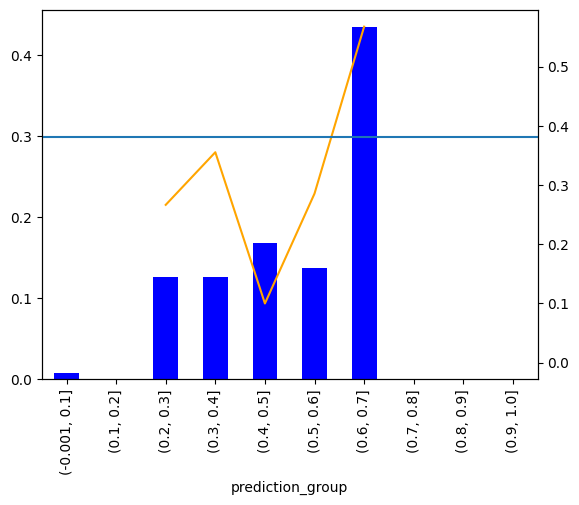

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       221
           1       0.00      0.00      0.00       136

    accuracy                           0.62       357
   macro avg       0.31      0.50      0.38       357
weighted avg       0.38      0.62      0.47       357

AUC Score: 0.6916589033803566


C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [68]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

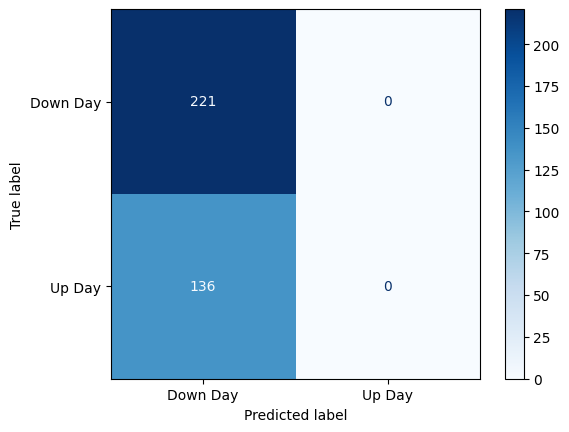

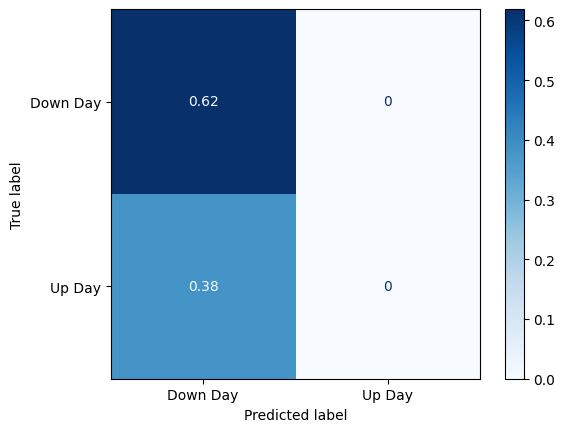

In [69]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [ ]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [70]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in Google stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in Google stock is: nan %


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_6524\2978561157.py:9: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)


# 3. Running the Random Forest model with best parameters (train + validation)

In [71]:
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


In [78]:
validation.to_csv('validation_df.csv')

In [72]:
train.shape

(1069, 19)

In [73]:
validation.shape

(357, 19)

In [75]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# Split X and y into X_
X_train, X_validation = train[X_Cols], validation[X_Cols]
y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(max_depth= 5, max_features= 8, n_estimators = 151, criterion = "gini", random_state = 711)
# rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1069,)

In [76]:
y_pred_proba

array([0.77679341, 0.77679341, 0.7787746 , 0.77679341, 0.78955991,
       0.78955991, 0.78955991, 0.79600815, 0.79600815, 0.79600815,
       0.78276133, 0.78955991, 0.77679341, 0.75716671, 0.7505442 ,
       0.65117287, 0.35087745, 0.35087745, 0.35087745, 0.35237447,
       0.35243256, 0.35243256, 0.35243256, 0.35243256, 0.35237447,
       0.35243256, 0.35243256, 0.35243256, 0.35237447, 0.35243256,
       0.35237447, 0.35237447, 0.7372173 , 0.35087745, 0.35427362,
       0.35427362, 0.35427362, 0.35237447, 0.35243256, 0.35243256,
       0.35243256, 0.35243256, 0.35243256, 0.35243256, 0.35243256,
       0.35243256, 0.35243256, 0.35243256, 0.35237447, 0.35237447,
       0.35243256, 0.35237447, 0.35237447, 0.35243256, 0.35243256,
       0.35243256, 0.35243256, 0.35243256, 0.35243256, 0.35243256,
       0.35243256, 0.35243256, 0.35243256, 0.78090987, 0.79246836,
       0.78602012, 0.79246836, 0.77325363, 0.7465409 , 0.52078178,
       0.33866169, 0.33866169, 0.33866169, 0.33866169, 0.33871

In [77]:
y_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [49]:
y_validation

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [74]:
model_thresh

0.8